In [125]:
import sympy as sp
from sympy import Array, symbols, factorial, tensorproduct, log, det, Matrix
from sympy.tensor.array import derive_by_array
from einsum_sympy import einsum_sympy
from dataclasses import dataclass
from sympy.utilities.lambdify import lambdify
import numpy as np
# For profiling (optional)
# import cProfile



Simulating...
Simulation finished. Generated data shapes:
x_series shape: (10001, 1)
y_series shape: (10001, 1)


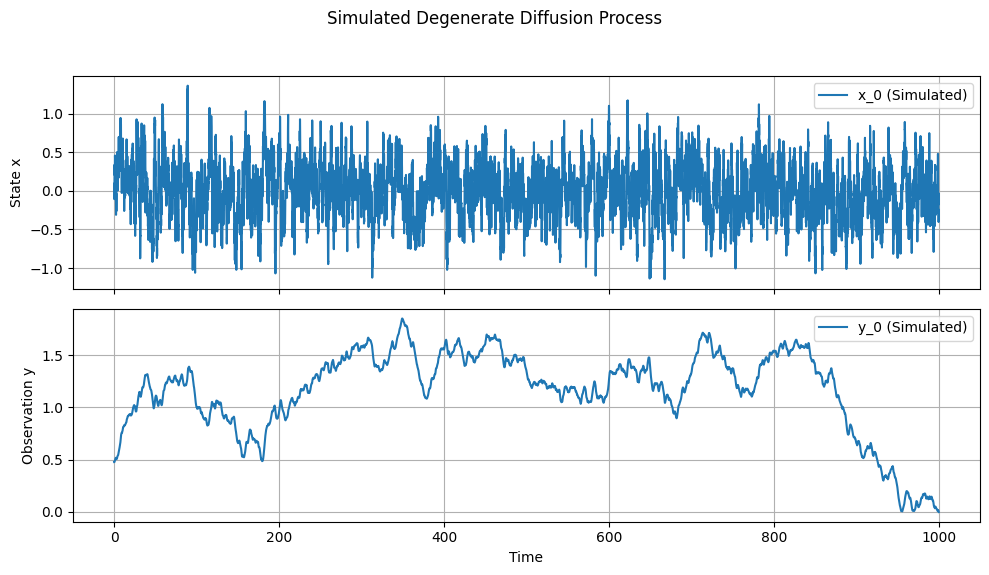

In [126]:
import sympy as sp
from sympy import Array, symbols, factorial, tensorproduct, log, det, Matrix
from sympy.tensor.array import derive_by_array
# from einsum_sympy import einsum_sympy # 元のコードにはあったが、このコードでは未使用のためコメントアウトしても良い
from dataclasses import dataclass
from sympy.utilities.lambdify import lambdify
import numpy as np
from typing import Tuple, Optional, Sequence # 型ヒント用に追加

@dataclass(frozen=True)
class DegenerateDiffusionProcess:
    """
    多次元の拡散過程と観測過程を扱うためのクラス。

    記号計算 (sympy) を用いてモデルを定義し、
    数値計算 (numpy) のための関数を lambdify で生成する。

    Attributes:
        x (sp.Array): 状態変数 (sympyシンボル配列, shape=(d_x,))
        y (sp.Array): 観測変数 (sympyシンボル配列, shape=(d_y,))
        theta_1 (sp.Array): パラメータ1 (sympyシンボル配列)
        theta_2 (sp.Array): パラメータ2 (sympyシンボル配列)
        theta_3 (sp.Array): パラメータ3 (sympyシンボル配列)
        A (sp.Array): ドリフト項の x 成分 (sympy式配列, shape=(d_x,))
        B (sp.Array): 拡散項 (sympy式配列, shape=(d_x, r))
        H (sp.Array): 観測過程のドリフト項 (sympy式配列, shape=(d_y,))
        # --- 以下は __post_init__ で自動生成 ---
        A_func : ドリフト A を計算する numpy 関数
        B_func : 拡散項 B を計算する numpy 関数
        H_func : 観測ドリフト H を計算する numpy 関数
    """

    x: sp.Array
    y: sp.Array
    theta_1: sp.Array
    theta_2: sp.Array
    theta_3: sp.Array
    A: sp.Array
    B: sp.Array
    H: sp.Array

    def __post_init__(self):
        """
        初期化後の設定処理。
        派生的な属性の計算、lambdifyによる関数生成を行う。
        frozen=True のため、属性設定には object.__setattr__ を使用する。
        """

        # --- lambdify による数値計算用関数の生成 ---
        common_args = (self.x, self.y)
        try:
            object.__setattr__(self, "A_func",
                               lambdify((*common_args, self.theta_2), self.A, modules="numpy"))
            object.__setattr__(self, "B_func",
                               lambdify((*common_args, self.theta_1), self.B, modules="numpy"))
            object.__setattr__(self, "H_func",
                               lambdify((*common_args, self.theta_3), self.H, modules="numpy"))

        except Exception as e:
            print(f"Error during lambdification in __post_init__: {e}")
            raise

    # --- シミュレーション関数 ---
    def simulate(
        self,
        true_theta: Tuple[np.ndarray, np.ndarray, np.ndarray], # 型ヒント追加
        t_max: float,
        h: float,
        burn_out: float,
        seed: int = 42,
        x0: Optional[np.ndarray] = None, # 型ヒント追加
        y0: Optional[np.ndarray] = None, # 型ヒント追加
        dt: float = 0.001,
    ) -> Tuple[np.ndarray, np.ndarray]: # 返り値の型ヒント追加
        """
        Euler-Maruyama法を用いて状態変数 x と観測変数 y の時系列データを生成する。

        Parameters:
            true_theta (tuple): (theta_1_val, theta_2_val, theta_3_val) の真値。
            t_max (float): 生成する時系列データの期間長（burn_out期間を除く）。
            h (float): 生成されるデータの時間ステップ幅（間引き後）。
            burn_out (float): 定常状態に達するまで捨てる初期期間。
            seed (int): 乱数生成器のシード値。
            x0 (np.ndarray, optional): x の初期値ベクトル。None の場合はゼロベクトル。
            y0 (np.ndarray, optional): y の初期値ベクトル。None の場合はゼロベクトル。
            dt (float): シミュレーション内部の微小時間ステップ幅。

        Returns:
            tuple[np.ndarray, np.ndarray]: (x_series, y_series)
                x_series: x の時系列データ (shape=(T, d_x))
                y_series: y の時系列データ (shape=(T, d_y))
                ここで T は t_max / h に近い整数
        """
        np.random.seed(seed)
        theta_1_val, theta_2_val, theta_3_val = true_theta
        total_steps = int(np.round((t_max + burn_out) / dt)) # 丸め処理追加
        d_x = self.x.shape[0]
        d_y = self.y.shape[0]
        r = self.B.shape[1] # Number of Wiener processes

        # dt と h の関係チェックと step_stride の計算
        if not np.isclose(h % dt, 0, atol=1e-8) and not np.isclose(h % dt, dt, atol=1e-8):
             print(f"Warning: h ({h}) may not be an integer multiple of dt ({dt}). Thinning interval might be slightly inaccurate due to rounding.")
        step_stride = max(1, int(np.round(h / dt))) # 丸めて最低1にする

        x_all = np.zeros((total_steps + 1, d_x))
        y_all = np.zeros((total_steps + 1, d_y))
        x_all[0] = x0 if x0 is not None else np.zeros(d_x)
        y_all[0] = y0 if y0 is not None else np.zeros(d_y)

        for t in range(total_steps):
            xt, yt = x_all[t], y_all[t]
            try:
                # self.*_func を直接呼び出す
                A_val = self.A_func(xt, yt, theta_2_val)
                B_val = self.B_func(xt, yt, theta_1_val)
                H_val = self.H_func(xt, yt, theta_3_val)
            except Exception as e:
                print(f"Error evaluating A, B, or H function at step {t}: {e}")
                print(f"xt={xt}, yt={yt}, theta_1={theta_1_val}, theta_2={theta_2_val}, theta_3={theta_3_val}")
                raise

            dW = np.random.randn(r) * np.sqrt(dt)
            diffusion_term = np.dot(B_val, dW) # np.dotを使用

            # 形状チェックをタプル (d_x,) と比較
            if diffusion_term.shape != (d_x,):
                raise ValueError(f"Shape mismatch in diffusion term: expected ({d_x},), got {diffusion_term.shape}")

            x_all[t + 1] = xt + A_val * dt + diffusion_term
            y_all[t + 1] = yt + H_val * dt
            # もし観測ノイズが必要な場合:
            # 例えば dy = H dt + G dV の G があるなら G_func を __post_init__ で作成
            # G_val = self.G_func(xt, yt, theta_g_val) # Gを計算
            # dV = np.random.randn(d_y) * np.sqrt(dt) # 観測ノイズの増分
            # y_all[t + 1] = yt + H_val * dt + np.dot(G_val, dV)

        # Apply burn-out and thinning
        start_index = int(np.round(burn_out / dt)) # 丸め処理追加

        x_series = x_all[start_index::step_stride]
        y_series = y_all[start_index::step_stride]

        return x_series, y_series

# --- 以下、使用例（元のコードにはなかったので参考として） ---
if __name__ == '__main__':
    # 例: 1次元 Ornstein-Uhlenbeck process (dx = -theta2*x dt + theta1 dW)
    #      観測 y は x に依存しない定数ドリフト (dy = theta3 dt)

    # シンボル定義
    x_sym = sp.Array([symbols('x_0')])
    y_sym = sp.Array([symbols('y_0')])
    theta1_sym = sp.Array([symbols('sigma')]) # diffusion coefficient
    theta2_sym = sp.Array([symbols('kappa')]) # reversion rate
    theta3_sym = sp.Array([symbols('mu')])    # observation drift

    # モデル定義
    A_expr = sp.Array([-theta2_sym[0] * x_sym[0]])
    B_expr = sp.Array([[theta1_sym[0]]]) # shape (d_x, r) = (1, 1)
    H_expr = sp.Array([theta3_sym[0] * x_sym[0]]) # shape (d_y,) = (1,)

    # インスタンス生成
    process = DegenerateDiffusionProcess(
        x=x_sym, y=y_sym,
        theta_1=theta1_sym, theta_2=theta2_sym, theta_3=theta3_sym,
        A=A_expr, B=B_expr, H=H_expr
    )

    # パラメータ真値
    true_sigma = np.array([0.5])
    true_kappa = np.array([1.0])
    true_mu = np.array([0.1])
    true_thetas = (true_sigma, true_kappa, true_mu)

    # シミュレーション実行
    T_MAX = 1000.0
    H_STEP = 0.1 # 間引き後のステップ幅
    BURN_OUT = 100.0
    DT_SIM = 0.01 # シミュレーション内部のステップ幅

    print("Simulating...")
    x_data, y_data = process.simulate(
        true_theta=true_thetas,
        t_max=T_MAX,
        h=H_STEP,
        burn_out=BURN_OUT,
        dt=DT_SIM,
        x0=np.array([0.0]),
        y0=np.array([0.0]),
        seed=123
    )

    print(f"Simulation finished. Generated data shapes:")
    print(f"x_series shape: {x_data.shape}") # (T, d_x)
    print(f"y_series shape: {y_data.shape}") # (T, d_y)

    # 簡単なプロット例 (matplotlibが必要)
    try:
        import matplotlib.pyplot as plt
        time = np.arange(x_data.shape[0]) * H_STEP
        fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
        ax[0].plot(time, x_data[:, 0], label='x_0 (Simulated)')
        ax[0].set_ylabel('State x')
        ax[0].grid(True)
        ax[0].legend()
        ax[1].plot(time, y_data[:, 0], label='y_0 (Simulated)')
        ax[1].set_xlabel('Time')
        ax[1].set_ylabel('Observation y')
        ax[1].grid(True)
        ax[1].legend()
        plt.suptitle('Simulated Degenerate Diffusion Process')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # suptitleとの重なり調整
        plt.show()
    except ImportError:
        print("\nMatplotlib not found. Skipping plot.")

derive_by_arrayは微分する方のインデックスが前に付くので注意（ヤコビ行列と逆になる）

In [129]:
# -*- coding: utf-8 -*-
import sympy as sp
from sympy import (Array, symbols, factorial, tensorproduct, log, det, Matrix,
                   Expr, Basic, S, zeros, srepr, oo)
from sympy.matrices.common import NonInvertibleMatrixError
from sympy.tensor.array import derive_by_array
from einsum_sympy import einsum_sympy
from sympy.utilities.lambdify import lambdify
import numpy as np
from numpy import einsum, power, isfinite, nan
from typing import TYPE_CHECKING, Dict, Callable, Tuple, Any, Optional


# --- 定数 ---
INVALID_SREPR_KEY = "invalid_sympy_srepr"

class LikelihoodEvaluator:
    """
    DegenerateDiffusionProcess モデルに基づき疑似尤度を計算するクラス。
    主要な記号的数式も属性として保持する。
    """

    def __init__(self, model: 'DegenerateDiffusionProcess'):
        """ LikelihoodEvaluator のインスタンスを初期化 """
        self.model = model
        self._L_cache: Dict[Tuple[int, str], Array] = {}
        self._L0_func_cache: Dict[Tuple[int, str], Callable] = {}
        self._S_func_cache: Dict[int, Tuple[Callable, ...]] = {}

        # --- モデル属性への参照 ---
        self.x = model.x
        self.y = model.y
        self.theta_1 = model.theta_1
        self.theta_2 = model.theta_2
        self.theta_3 = model.theta_3
        self.A = model.A  # sympy expression
        self.B = model.B  # sympy expression
        self.H = model.H  # sympy expression

        # --- モデルから lambdify 済み関数を取得 ---
        required_funcs = ['A_func', 'B_func', 'H_func']
        if not all(hasattr(model, func_name) and callable(getattr(model, func_name)) for func_name in required_funcs):
            missing = [f for f in required_funcs if not hasattr(model, f) or not callable(getattr(model, f))]
            raise AttributeError(f"Provided model instance is missing required callable functions: {missing}")
        self.A_func = model.A_func
        self.B_func = model.B_func
        self.H_func = model.H_func
        
        common_args = (self.x, self.y)

        # --- 派生的な記号計算と lambdify ---
        # 各シンボリックな式も属性として保存する
        try:
            # C = B B^T
            self.C_sym = einsum_sympy("ik,jk->ij", self.B, self.B)
            self.C_func = lambdify((*common_args, self.theta_1), self.C_sym, modules="numpy")

            C_matrix = Matrix(self.C_sym)
            self.inv_C_expr = None
            self.log_det_C_expr = None
            try:
                self.inv_C_expr = Array(C_matrix.inv())
                self.inv_C_func = lambdify((*common_args, self.theta_1), self.inv_C_expr, modules="numpy")
            except NonInvertibleMatrixError:
                print("Warning: Symbolic matrix C is not invertible. inv_C_expr and inv_C_func set to None.")
                self.inv_C_func = None # inv_C_expr は既に None で初期化済み
            except Exception as e:
                print(f"Warning: Error inverting C matrix or lambdifying: {e}. inv_C_expr and inv_C_func set to None.")
                self.inv_C_func = None


            try:
                det_C_val = C_matrix.det()
                if det_C_val.is_nonpositive:
                    print("Warning: Symbolic det(C) is non-positive. log_det_C_expr and log_det_C_func set to None.")
                    self.log_det_C_func = None
                elif det_C_val == 0:
                    print("Warning: Symbolic det(C) is zero. log_det_C_expr set to -oo (func to None).")
                    self.log_det_C_expr = -oo 
                    self.log_det_C_func = None
                else:
                    self.log_det_C_expr = log(det_C_val)
                    self.log_det_C_func = lambdify((*common_args, self.theta_1), self.log_det_C_expr, modules="numpy")
            except Exception as e:
                print(f"Warning: Could not reliably determine sign of det(C) or log failed ({e}). log_det_C_expr and log_det_C_func set to None.")
                self.log_det_C_func = None

            # dH/dx
            self.partial_x_H_sym = derive_by_array(self.H, self.x)
            # self.partial_x_H_func は必要に応じて作成 (V3などで使用)
            # self.partial_x_H_func = lambdify((*common_args, self.theta_3), self.partial_x_H_sym, modules="numpy")


            # V = (dH/dx) C (dH/dx)^T
            self.V_sym = einsum_sympy("ki,kl,lj->ij", self.partial_x_H_sym, self.C_sym, self.partial_x_H_sym)
            self.V_func = lambdify((*common_args, self.theta_1, self.theta_3), self.V_sym, modules="numpy")
            
            V_matrix = Matrix(self.V_sym)
            self.inv_V_expr = None
            self.log_det_V_expr = None
            try:
                self.inv_V_expr = Array(V_matrix.inv())
                self.inv_V_func = lambdify((*common_args, self.theta_1, self.theta_3), self.inv_V_expr, modules="numpy")
            except NonInvertibleMatrixError:
                print("Warning: Symbolic matrix V is not invertible. inv_V_expr and inv_V_func set to None.")
                self.inv_V_func = None
            except Exception as e:
                print(f"Warning: Error inverting V matrix or lambdifying: {e}. inv_V_expr and inv_V_func set to None.")
                self.inv_V_func = None

            try:
                det_V_val = V_matrix.det()
                # det <= 0 の場合 log で ValueError が発生するのを避ける (lambdify 時も考慮)
                if det_V_val.is_nonpositive: # Sympy の is_nonpositive で判定
                    print("Warning: Symbolic det(V) is non-positive. log_det_V_expr and log_det_V_func set to None.")
                    self.log_det_V_func = None
                elif det_V_val == 0:
                    print("Warning: Symbolic det(V) is zero. log_det_V_expr set to -oo (func to None).")
                    self.log_det_V_expr = -oo
                    self.log_det_V_func = None
                else:
                    self.log_det_V_expr = log(det_V_val)
                    self.log_det_V_func = lambdify((*common_args, self.theta_1, self.theta_3), self.log_det_V_expr, modules="numpy")
            except Exception as e: # is_nonpositive が判定不能な場合など
                print(f"Warning: Could not reliably determine sign of det(V) or log failed ({e}). log_det_V_expr and log_det_V_func set to None.")
                self.log_det_V_func = None

            # (dH/dx)^T inv(V)
            self.partial_x_H_transpose_inv_V_expr = None
            if self.inv_V_expr is not None: # inv_V_expr が計算できた場合のみ
                try:
                    # partial_x_H_sym は (d_y, d_x), inv_V_expr は (d_y, d_y)
                    # 結果は (d_x, d_y) になるように転置と積の順番を調整
                    # (dH/dx)^T は (d_x, d_y)
                    # (dH/dx)^T @ inv(V) は (d_x, d_y) @ (d_y, d_y) -> (d_x, d_y)
                    self.partial_x_H_transpose_inv_V_expr = einsum_sympy("ji,jk->ik", self.partial_x_H_sym, self.inv_V_expr)
                    self.partial_x_H_transpose_inv_V_func = lambdify(
                        (*common_args, self.theta_1, self.theta_3),
                        self.partial_x_H_transpose_inv_V_expr, modules="numpy"
                    )
                except Exception as e:
                    print(f"Error creating partial_x_H_transpose_inv_V_expr or func: {e}")
                    self.partial_x_H_transpose_inv_V_func = None
            else:
                self.partial_x_H_transpose_inv_V_func = None


            # S0 関連のシンボリックな式を初期化
            self.inv_S0_xx_expr = None
            self.inv_S0_xy_expr = None
            self.inv_S0_yx_expr = None
            self.inv_S0_yy_expr = None
            self.log_det_S0_expr = None

            # inv_S0_xx, inv_S0_xy, inv_S0_yx, inv_S0_yyを計算する
            if self.inv_C_expr is not None and self.inv_V_expr is not None and self.partial_x_H_transpose_inv_V_expr is not None:
                try:
                    # S_0^{-1}_xx = C^{-1} + 3 (dH/dx)^T V^{-1} (dH/dx)
                    # partial_x_H_transpose_inv_V_expr (ik) is (d_x, d_y)
                    # self.partial_x_H_sym (lj) is (d_y, d_x)
                    # einsum('ik,lj->il', (dH/dx)^T V^{-1} , dH/dx) where k=l
                    # -> einsum('ik,kj->ij', (dH/dx)^T V^{-1} , dH/dx)
                    term_for_invS0xx = einsum_sympy('ik,kj->ij', self.partial_x_H_transpose_inv_V_expr, self.partial_x_H_sym)
                    self.inv_S0_xx_expr = self.inv_C_expr + 3 * term_for_invS0xx
                    self.inv_S0_xx_func = lambdify(
                        (*common_args, self.theta_1, self.theta_3), # theta_1 for C, theta_1, theta_3 for V and dHdx
                        self.inv_S0_xx_expr, modules="numpy"
                    )
                except Exception as e:
                    print(f"Error creating inv_S0_xx_expr or func: {e}")
                    self.inv_S0_xx_func = None
                
                try:
                    # S_0^{-1}_xy = -6 (dH/dx)^T V^{-1}
                    self.inv_S0_xy_expr = -6 * self.partial_x_H_transpose_inv_V_expr
                    self.inv_S0_xy_func = lambdify(
                        (*common_args, self.theta_1, self.theta_3),
                        self.inv_S0_xy_expr, modules="numpy"
                    )
                except Exception as e:
                    print(f"Error creating inv_S0_xy_expr or func: {e}")
                    self.inv_S0_xy_func = None

                try:
                    # S_0^{-1}_yx = -6 V^{-1} (dH/dx)
                    # inv_V_expr (ik) is (d_y, d_y)
                    # self.partial_x_H_sym (kj) is (d_y, d_x)
                    # einsum('ik,kj->ij', inv_V_expr, self.partial_x_H_sym) -> (d_y, d_x)
                    self.inv_S0_yx_expr = -6 * einsum_sympy('ik,kj->ij', self.inv_V_expr, self.partial_x_H_sym)
                    # または self.inv_S0_yx_expr = Array(sp.transpose(Matrix(self.inv_S0_xy_expr))) でも可のはず
                    self.inv_S0_yx_func = lambdify(
                        (*common_args, self.theta_1, self.theta_3),
                        self.inv_S0_yx_expr, modules="numpy"
                    )
                except Exception as e:
                    print(f"Error creating inv_S0_yx_expr or func: {e}")
                    self.inv_S0_yx_func = None

                try:
                    # S_0^{-1}_yy = 12 V^{-1}
                    self.inv_S0_yy_expr = 12 * self.inv_V_expr
                    self.inv_S0_yy_func = lambdify(
                        (*common_args, self.theta_1, self.theta_3),
                        self.inv_S0_yy_expr, modules="numpy"
                    )
                except Exception as e:
                    print(f"Error creating inv_S0_yy_expr or func: {e}")
                    self.inv_S0_yy_func = None
            else:
                print("Warning: Could not create inv_S0_xx, inv_S0_xy, inv_S0_yx, inv_S0_yy expressions/functions due to previous errors with C_inv, V_inv or dHdx_T_V_inv.")
                self.inv_S0_xx_func = None
                self.inv_S0_xy_func = None
                self.inv_S0_yx_func = None
                self.inv_S0_yy_func = None
            
            # log_det_S0の計算
            if self.log_det_C_expr is not None and self.log_det_V_expr is not None and \
               self.log_det_C_expr != -oo and self.log_det_V_expr != -oo :
                try:
                    d_y = self.y.shape[0]
                    # log(det(S0)) = log(det(C)) + log(det(V)) + d_y * log(1/12)
                    # log(1/12) = -log(12)
                    self.log_det_S0_expr = self.log_det_C_expr + self.log_det_V_expr 
                    self.log_det_S0_func = lambdify(
                        (*common_args, self.theta_1, self.theta_3),
                        self.log_det_S0_expr, modules="numpy"
                    )
                except Exception as e:
                    print(f"Error creating log_det_S0_expr or func: {e}")
                    self.log_det_S0_func = None
            else:
                print("Warning: Could not create log_det_S0_expr or func due to issues with log_det_C or log_det_V.")
                if self.log_det_C_expr == -oo or self.log_det_V_expr == -oo:
                     self.log_det_S0_expr = -oo # detが0ならlog(det)は-oo
                self.log_det_S0_func = None

        except Exception as e:
            print(f"CRITICAL Error during symbolic calc/lambdify in LikelihoodEvaluator __init__: {e}")
            # ここで None に設定されていない可能性のある関数も None にしておく
            self.C_func = None
            self.inv_C_func = None
            self.log_det_C_func = None
            self.V_func = None
            self.inv_V_func = None
            self.log_det_V_func = None
            self.partial_x_H_transpose_inv_V_func = None
            self.inv_S0_xx_func = None
            self.inv_S0_xy_func = None
            self.inv_S0_yx_func = None
            self.inv_S0_yy_func = None
            self.log_det_S0_func = None
            raise

    # --- キャッシュキーヘルパー (変更なし) ---
    def _get_tensor_srepr(self, tensor: Basic) -> str:
        try:
            if isinstance(tensor, Array):
                return srepr(tensor.tolist())
            else:
                return srepr(tensor)
        except Exception as e:
            print(f"Warning: srepr failed for {type(tensor)}. Using fallback. Error: {e}")
            return INVALID_SREPR_KEY

    # --- Infinitesimal Generator L (変更なし) ---
    def _L_elem_once(self, f_elem: Basic) -> Basic:
        if not isinstance(f_elem, Expr) or f_elem.is_constant(simplify=False):
            return S(0)
        try:
            f_elem_sym = sp.sympify(f_elem)
            df_dx = derive_by_array(f_elem_sym, self.x)
            df_dy = derive_by_array(f_elem_sym, self.y)
            d2f_dx2 = derive_by_array(df_dx, self.x)
            
            # self.C_sym は __init__ で計算済みのシンボリックな C
            C_term_sym = self.C_sym 

            term1 = einsum_sympy("i,i->", self.A, df_dx)
            term2 = einsum_sympy("i,i->", self.H, df_dy)
            term3 = (S(1) / 2) * einsum_sympy("ij,ij->", C_term_sym, d2f_dx2)
            result = term1 + term2 + term3
            return result
        except Exception as e:
            print(f"Error applying _L_elem_once to: {type(f_elem)} with srepr: {self._get_tensor_srepr(f_elem)}")
            raise

    def L(self, f_tensor: Basic, k: int) -> Basic:
        cache_key = (k, self._get_tensor_srepr(f_tensor))
        if cache_key in self._L_cache:
            return self._L_cache[cache_key]

        if k == 0:
            result = f_tensor
        elif k < 0:
            raise ValueError("Order k must be non-negative")
        else:
            f_prev = self.L(f_tensor, k - 1)
            try:
                if isinstance(f_prev, Array) and hasattr(f_prev, 'applyfunc'):
                    result = f_prev.applyfunc(self._L_elem_once)
                elif isinstance(f_prev, (Expr, Basic)):
                    result = self._L_elem_once(f_prev)
                else:
                    print(f"Warning: Applying L to non-symbolic {type(f_prev)} in L(k={k}).")
                    result = zeros(*f_prev.shape) if hasattr(f_prev, 'shape') else S(0)
            except Exception as e:
                print(f"Error in L applying L once for k={k}")
                print(f"L^{k-1}(f): {type(f_prev)}, srepr: {self._get_tensor_srepr(f_prev)}")
                raise
        self._L_cache[cache_key] = result
        return result
    
    def L_0(self, f_tensor: Basic, k: int) -> Basic:
        if k < 0:
            raise ValueError("k must be non-negative")
        Lk_f = self.L(f_tensor, k)
        fact_k = factorial(k)
        if fact_k == 0: # Should only happen if k is not a non-negative integer, but factorial(0)=1
             raise ValueError(f"Factorial({k}) is zero? This should not happen.")
        
        try:
            if isinstance(Lk_f, Array) and hasattr(Lk_f, 'applyfunc'):
                # Make sure division by sympy.Integer works for Array elements
                result = Lk_f.applyfunc(lambda elem: elem / S(fact_k))
            elif isinstance(Lk_f, (Expr, Basic)):
                result = Lk_f / S(fact_k) # Use S(fact_k) for symbolic division
            else: # e.g. numpy array if something went wrong or for testing
                result = Lk_f / float(fact_k)
        except Exception as e:
            print(f"Error in L_0 dividing by factorial({k})")
            print(f"Lk_f type: {type(Lk_f)}, srepr: {self._get_tensor_srepr(Lk_f)}")
            raise
        return result

    def L_0_func(self, f_tensor: Basic, k: int) -> Callable:
        cache_key = (k, self._get_tensor_srepr(f_tensor))
        if cache_key in self._L0_func_cache:
            return self._L0_func_cache[cache_key]
        else:
            try:
                L0_expr_val = self.L_0(f_tensor, k)
                # lambdifyの引数に self.model のシンボルを渡す
                lambdify_args = (self.x, self.y,
                                 self.theta_1, self.theta_2, self.theta_3)
                
                # Check if L0_expr_val contains any free symbols not in lambdify_args
                # free_symbols_in_expr = L0_expr_val.free_symbols if hasattr(L0_expr_val, 'free_symbols') else set()
                # if isinstance(L0_expr_val, Array):
                #     free_symbols_in_expr = set()
                #     for elem in L0_expr_val:
                #         free_symbols_in_expr.update(elem.free_symbols if hasattr(elem, 'free_symbols') else set())
                
                # arg_symbols = set(s for arr in [self.x, self.y, self.theta_1, self.theta_2, self.theta_3] for s in arr)
                # if not free_symbols_in_expr.issubset(arg_symbols):
                #     print(f"Warning: L0_expr for k={k}, srepr={cache_key[1]} contains free symbols not in lambdify args: {free_symbols_in_expr - arg_symbols}")

                func = lambdify(lambdify_args, L0_expr_val, modules="numpy")
                self._L0_func_cache[cache_key] = func
                return func
            except Exception as e:
                print(f"Error creating L_0_func for k={k}, srepr={cache_key[1]}")
                print(f"Expression was: {L0_expr_val if 'L0_expr_val' in locals() else 'undefined'}")
                raise

    # --- Auxiliary functions for Quasi-Likelihood ---
    def Dx_func(self, L0_x_funcs: Dict[int, Callable],
                x_j: np.ndarray, x_j_1: np.ndarray, y_j_1: np.ndarray,
                # theta_2_val_for_A: np.ndarray, # A(theta_2) を評価するパラメータ
                theta_2_val: np.ndarray, # A(theta_2) を評価するパラメータ
                theta_1_bar: np.ndarray, theta_2_bar: np.ndarray, theta_3_bar: np.ndarray, # L0(bar) 用
                h: float, k_arg: int) -> np.ndarray: # k_arg は数式 D^k の k に対応
        if h <= 0:
            return np.zeros_like(x_j)
        DX_SCALE = power(h, -0.5)
        
        D_x = DX_SCALE * (x_j - x_j_1) # Base term for k_arg = 0

        if k_arg >= 1: # A term is present if k_arg is 1 or more
            try:
                # V1 の場合、D^{k-1}(bar_theta) を使うので A は theta_2_bar で評価
                A_val = self.A_func(x_j_1, y_j_1, theta_2_val) 
            except Exception as e:
                raise RuntimeError(f"Dx_func: A_func eval error: {e}") from e
            D_x -= DX_SCALE * power(h, 1) * A_val
        
        if k_arg >= 2: # Summation term is present if k_arg is 2 or more
            args_for_L0_bar = (x_j_1, y_j_1, theta_1_bar, theta_2_bar, theta_3_bar)
            for m_loop in range(2, k_arg + 1): # Sum from m=2 to k_arg
                h_pow_m = power(h, m_loop)
                try:
                    L0_x_m_val = L0_x_funcs[m_loop](*args_for_L0_bar)
                except KeyError as e:
                    raise RuntimeError(f"Dx_func: L0_x_funcs key m={m_loop} not found (dict has keys for m up to {max(L0_x_funcs.keys()) if L0_x_funcs else 'empty'}). k_arg was {k_arg}.") from e
                except Exception as e:
                    raise RuntimeError(f"Dx_func: L0_x_funcs[{m_loop}] eval error: {e}") from e
                D_x -= DX_SCALE * h_pow_m * L0_x_m_val
        return D_x

    def Dy_func(self, L0_y_funcs: Dict[int, Callable],
                y_j: np.ndarray, y_j_1: np.ndarray, x_j_1: np.ndarray,
                theta_3_val: np.ndarray, # H(theta_3) を評価するパラメータ
                theta_1_bar: np.ndarray, theta_2_bar: np.ndarray, theta_3_bar: np.ndarray, # L0(bar) 用
                h: float, k_arg: int) -> np.ndarray: # k_arg は数式 D^k の k に対応
        if h <= 0:
            return np.zeros_like(y_j)
        DY_SCALE = power(h, -1.5)
        
        D_y = DY_SCALE * (y_j - y_j_1) # Base term for k_arg = 0

        if k_arg >= 1: # H term is present if k_arg is 1 or more
            try:
                # V1 の場合、D^{k-1}(bar_theta) を使うので H は theta_3_bar で評価
                H_val = self.H_func(x_j_1, y_j_1, theta_3_val)
            except Exception as e:
                raise RuntimeError(f"Dy_func: H_func eval error: {e}") from e
            D_y -= DY_SCALE * power(h, 1) * H_val
            
        if k_arg >= 2: # Summation term is present if k_arg is 2 or more
            args_for_L0_bar = (x_j_1, y_j_1, theta_1_bar, theta_2_bar, theta_3_bar)
            # For D^k_y, the sum is from m=2 to k+1
            for m_loop in range(2, k_arg + 2): # Sum from m=2 to k_arg+1
                h_pow_m = power(h, m_loop)
                try:
                    L0_y_m_val = L0_y_funcs[m_loop](*args_for_L0_bar)
                except KeyError as e:
                    raise RuntimeError(f"Dy_func: L0_y_funcs key m={m_loop} not found (dict has keys for m up to {max(L0_y_funcs.keys()) if L0_y_funcs else 'empty'}). k_arg was {k_arg}.") from e
                except Exception as e:
                    raise RuntimeError(f"Dy_func: L0_y_funcs[{m_loop}] eval error: {e}") from e
                D_y -= DY_SCALE * h_pow_m * L0_y_m_val
        return D_y
        
    # --- S 項の計算 (変更なし) ---
    def S(self, k: int) -> Tuple[Array, Array, Array, Array]:
        x_sym = self.x
        y_sym = self.y
        
        # T terms: E[X_i X_j], E[X_i Y_j] etc. at higher orders
        # T_xx = L_0( tensor(x,x), k+1) means ( L^(k+1) (x tensor x) ) / (k+1)!
        T_xx = self.L_0(tensorproduct(x_sym, x_sym), k + 1)
        T_xy = self.L_0(tensorproduct(x_sym, y_sym), k + 2) 
        T_yx = self.L_0(tensorproduct(y_sym, x_sym), k + 2)
        T_yy = self.L_0(tensorproduct(y_sym, y_sym), k + 3)

        def compute_U_component(f1: Array, f2: Array, total_sum_order: int) -> Array:
            if not (isinstance(f1, Array) and f1.rank() == 1):
                raise ValueError(f"U computation requires rank-1 Array for f1, got {type(f1)}")
            if not (isinstance(f2, Array) and f2.rank() == 1):
                raise ValueError(f"U computation requires rank-1 Array for f2, got {type(f2)}")

            # Initialize U_component as a symbolic zero array of the correct shape
            # This ensures symbolic addition works correctly.
            # Assuming f1 and f2 are 1D arrays (vectors)
            u_shape = (f1.shape[0], f2.shape[0])
            U_component = Array(zeros(*u_shape))


            for m1 in range(total_sum_order + 1):
                m2 = total_sum_order - m1
                try:
                    L0_f1_m1 = self.L_0(f1, m1) # L^m1(f1)/m1!
                    L0_f2_m2 = self.L_0(f2, m2) # L^m2(f2)/m2!
                    
                    # tensorproduct should handle Array inputs correctly
                    term = tensorproduct(L0_f1_m1, L0_f2_m2)
                    
                    if term.shape != u_shape:
                        # Attempt to reshape if the number of elements is the same
                        if np.prod(term.shape) == np.prod(u_shape):
                            print(f"Warning: compute_U_component term shape mismatch ({term.shape} vs {u_shape}). Reshaping.")
                            term = Array(term).reshape(*u_shape)
                        else:
                            raise ValueError(f"compute_U_component term shape mismatch ({term.shape} vs {u_shape}) and cannot reshape.")
                    
                    U_component = U_component + term
                except Exception as e:
                    raise RuntimeError(f"Error in compute_U_component for f1={f1}, f2={f2}, m1={m1}, m2={m2}: {e}") from e
            return Array(U_component) # Ensure it's an Array

        # U terms: Sum_{m1+m2=total_order} (L^m1(f1)/m1!) tensor (L^m2(f2)/m2!)
        U_xx = compute_U_component(x_sym, x_sym, k + 1)
        U_xy = compute_U_component(x_sym, y_sym, k + 2)
        U_yx = compute_U_component(y_sym, x_sym, k + 2)
        U_yy = compute_U_component(y_sym, y_sym, k + 3)

        try:
            # Ensure T and U are compatible for subtraction (both are Sympy Arrays)
            S_xx = Array(T_xx) - Array(U_xx)
            S_xy = Array(T_xy) - Array(U_xy)
            S_yx = Array(T_yx) - Array(U_yx)
            S_yy = Array(T_yy) - Array(U_yy)
        except Exception as e:
            raise RuntimeError(f"Error subtracting U from T for S(k={k}): {e}. Types: T_xx={type(T_xx)}, U_xx={type(U_xx)}") from e
            
        return S_xx, S_xy, S_yx, S_yy

    def S_func(self, k: int) -> Tuple[Callable, Callable, Callable, Callable]:
        cache_key = k 
        if cache_key in self._S_func_cache:
            return self._S_func_cache[cache_key]
        else:
            try:
                S_k = self.S(k)
                S_xx_expr = S_k[0]
                S_xy_expr = S_k[1]
                S_yx_expr = S_k[2]
                S_yy_expr = S_k[3]
                lambdify_args = (self.x, self.y,self.theta_1, self.theta_2, self.theta_3)
                f_xx = lambdify(lambdify_args, S_xx_expr, modules="numpy")
                f_xy = lambdify(lambdify_args, S_xy_expr, modules="numpy")
                f_yx = lambdify(lambdify_args, S_yx_expr, modules="numpy")
                f_yy = lambdify(lambdify_args, S_yy_expr, modules="numpy")
                
                funcs = (f_xx, f_xy, f_yx, f_yy)
                self._S_func_cache[cache_key] = funcs
                return funcs
            except Exception as e:
                print(f"Error creating S_func for k={k}: {e}")
                raise

    # --- Quasi-Likelihood Evaluator Factories (変更なし) ---
    # make_quasi_likelihood_v1_prime_evaluator, 
    # make_quasi_likelihood_v1_evaluator,
    # make_quasi_likelihood_v2_evaluator,
    # make_quasi_likelihood_v3_evaluator
    # の実装は前回のコードと同じなので省略します。
    # EVALUATOR_FACTORIES_START
    def make_quasi_likelihood_v1_prime_evaluator(self, x_series: np.ndarray, y_series: np.ndarray, h: float, k: int) -> Callable:
        n = x_series.shape[0]
        d_x = self.x.shape[0]
        num_transitions = n - 1
        if num_transitions < 1 or y_series.shape[0] != n:
            raise ValueError("Time series length must be > 1 and shapes must match for V1'.")

        try:
            # Dx の展開次数は k-1 まで。L0_x_funcs のキーは 0 から k-1 まで。
            # Dx_funcの引数kは L0の最高次数+1 なので、Dx_func(..., k_dx) のとき L0_x_funcs は k_dx 次まで必要。
            # V1'の論文ではDxの展開次数はk-1なので L0_x_funcsは range(k) => {0, ..., k-1}
            L0_x_funcs = {m: self.L_0_func(self.x, m) for m in range(k)} # m = 0, ..., k-1
            # S_l の展開次数は k-1 まで。S_func の引数は l で、l=1,...,k-1
            S_l_funcs = {l_s: self.S_func(l_s) for l_s in range(1, k)} # l_s = 1, ..., k-1
        except Exception as e:
            raise RuntimeError(f"V1' precalculation error: {e}") from e
        
        if self.inv_C_func is None or self.log_det_C_func is None:
            raise RuntimeError("inv_C_func or log_det_C_func is missing for V1'. Check __init__ warnings.")

        def evaluate_v1_prime(theta_1_val: np.ndarray,
                              theta_1_bar: np.ndarray,
                              theta_2_bar: np.ndarray,
                              theta_3_bar: np.ndarray) -> float:
            total_log_likelihood = 0.0
            for j_idx in range(1, n):
                x_j = x_series[j_idx]
                # y_j = y_series[j_idx] # Not directly used in V1' formula terms
                x_j_1 = x_series[j_idx - 1]
                y_j_1 = y_series[j_idx - 1]
                try:
                    invC_val = self.inv_C_func(x_j_1, y_j_1, theta_1_val) # Depends on theta_1_val
                    logDetC_val = self.log_det_C_func(x_j_1, y_j_1, theta_1_val) # Depends on theta_1_val
                except Exception as e:
                    print(f"Error during inv_C or log_det_C evaluation at step j={j_idx}: {e}")
                try:
                    # Dx_func の k は L0 の最高次数。V1'では k-1 次まで展開。
                    # L0_x_funcs は 0 から k-1 までの関数を持つ。
                    # Dx_func に渡す k は、L0_x_funcs の最大の m と同じにする。
                    # つまり、Dx(k-1) を計算するなら、L0_x_funcs は range(k-1+1) = range(k) => {0,...,k-1}
                    Dx_k_param = k -1 
                    Dx_val = self.Dx_func(L0_x_funcs, x_j, x_j_1, y_j_1,
                                          theta_2_bar, # A(theta_2_bar)
                                          theta_1_bar, theta_2_bar, theta_3_bar, # L0s(theta_bar)
                                          h, Dx_k_param) 
                except Exception as e:
                    print(f"Error during Dx_func evaluation at step j={j_idx}: {e}")
                try:
                    sum_Sxx_val = np.zeros((d_x, d_x), dtype=float)
                    for l_s_loop in range(1, k): # l_s = 1 to k-1
                        Sxx_func_l = S_l_funcs[l_s_loop][0] # S_xx for S_l
                        Sxx_l_val = Sxx_func_l(x_j_1, y_j_1, theta_1_bar, theta_2_bar, theta_3_bar)
                        sum_Sxx_val += power(h, l_s_loop) * Sxx_l_val
                except Exception as e:
                    print(f"Error during Sxx_func evaluation at step j={j_idx}: {e}")
                try:
                    # V1' Likelihood terms
                    # Term1: - Dx^T inv(C) Dx
                    term1_quad = -einsum("ij,i,j", invC_val, Dx_val, Dx_val)
                    # Term2: Tr(inv(C) * sum(h^l S_xx^(l)))
                    term2_trace = +einsum("ij,ji", invC_val, sum_Sxx_val) # sumSxx_val is already h^l * S_xx
                    # Term3: -log(det(C))
                    term3_logdet = -logDetC_val
                    
                    step_likelihood = term1_quad + term2_trace + term3_logdet
                    if not isfinite(step_likelihood):
                        print(f"Warning: V1' eval at j={j_idx} is non-finite: {step_likelihood}")
                        print(f"  T1_quad={term1_quad}, T2_trace={term2_trace}, T3_logdet={term3_logdet}")
                        print(f"  invC={invC_val}, Dx={Dx_val}, sumSxx={sum_Sxx_val}, logDetC={logDetC_val}")
                        return nan
                    total_log_likelihood += step_likelihood
                except Exception as e:
                    print(f"Error during V1' evaluation at step j={j_idx}: {e}")
                    print(f"  Inputs: x_j1={x_j_1}, y_j1={y_j_1}, th1_val={theta_1_val}, th_bars=...")
                    return nan
            # Factor 1/2 is typical for log-likelihood of Gaussian
            return total_log_likelihood / (2.0 * num_transitions) if num_transitions > 0 else nan
        return evaluate_v1_prime

    def make_quasi_likelihood_v1_evaluator(self, x_series: np.ndarray, y_series: np.ndarray, h: float, k: int) -> Callable:
        n = x_series.shape[0]
        d_x = self.x.shape[0]
        d_y = self.y.shape[0]
        num_transitions = n - 1
        if num_transitions < 1 or y_series.shape[0] != n:
            raise ValueError("Time series length must be > 1 and shapes must match for V1.")

        try:
            # Dx の展開次数は k-1。 L0_x_funcs は range(k) => {0,...,k-1}
            L0_x_funcs = {m: self.L_0_func(self.x, m) for m in range(k)}
            # Dy の展開次数は k。   L0_y_funcs は range(k+1) => {0,...,k}
            L0_y_funcs = {m: self.L_0_func(self.y, m) for m in range(k + 1)}
            # S_l の展開次数は k-1。 S_l_funcs は l=1,...,k-1
            S_l_funcs = {l_s: self.S_func(l_s) for l_s in range(1, k)}
        except Exception as e:
            raise RuntimeError(f"V1 precalculation error: {e}") from e

        # Check if S0 related functions were successfully created
        s0_funcs_needed = [self.inv_S0_xx_func, self.inv_S0_xy_func, 
                           self.inv_S0_yx_func, self.inv_S0_yy_func, self.log_det_S0_func]
        if any(f is None for f in s0_funcs_needed):
            missing_s0_func_names = [
                name for name, func in zip(
                    ["inv_S0_xx_func", "inv_S0_xy_func", "inv_S0_yx_func", "inv_S0_yy_func", "log_det_S0_func"],
                    s0_funcs_needed
                ) if func is None
            ]
            raise RuntimeError(f"S0 related functions {missing_s0_func_names} are missing for V1. Check __init__ warnings.")

        def evaluate_v1(theta_1_val: np.ndarray,
                        theta_1_bar: np.ndarray,
                        theta_2_bar: np.ndarray,
                        theta_3_bar: np.ndarray) -> float:
            total_log_likelihood = 0.0
            for j_idx in range(1, n):
                x_j = x_series[j_idx]
                y_j = y_series[j_idx]
                x_j_1 = x_series[j_idx - 1]
                y_j_1 = y_series[j_idx - 1]
                try:
                    # inv_S0 functions depend on theta_1_val (for C part) and theta_3_bar (for V part)
                    inv_S0_xx_val = self.inv_S0_xx_func(x_j_1, y_j_1, theta_1_val, theta_3_bar)
                    inv_S0_xy_val = self.inv_S0_xy_func(x_j_1, y_j_1, theta_1_val, theta_3_bar)
                    inv_S0_yx_val = self.inv_S0_yx_func(x_j_1, y_j_1, theta_1_val, theta_3_bar)
                    inv_S0_yy_val = self.inv_S0_yy_func(x_j_1, y_j_1, theta_1_val, theta_3_bar)
                    
                    # log_det_S0 depends on theta_1_val and theta_3_bar
                    log_det_S0_val = self.log_det_S0_func(x_j_1, y_j_1, theta_1_val, theta_3_bar)

                    # Dx(k-1) and Dy(k)
                    Dx_k_param = k - 1 # For Dx, up to L0_x_funcs[k-1]
                    Dy_k_param = k - 1    # For Dy, up to L0_y_funcs[k]

                    Dx_val = self.Dx_func(L0_x_funcs, x_j, x_j_1, y_j_1,
                                          theta_2_bar, # A(theta_2_bar)
                                          theta_1_bar, theta_2_bar, theta_3_bar, # L0s(theta_bar)
                                          h, Dx_k_param)
                    Dy_val = self.Dy_func(L0_y_funcs, y_j, y_j_1, x_j_1,
                                          theta_3_bar, # H(theta_3_bar)
                                          theta_1_bar, theta_2_bar, theta_3_bar, # L0s(theta_bar)
                                          h, Dy_k_param)

                    # Sum of S terms (S_xx, S_xy, S_yx, S_yy)
                    # These are S^(l) for l=1 to k-1
                    sum_S_xx = np.zeros((d_x, d_x), dtype=float)
                    sum_S_xy = np.zeros((d_x, d_y), dtype=float)
                    sum_S_yx = np.zeros((d_y, d_x), dtype=float)
                    sum_S_yy = np.zeros((d_y, d_y), dtype=float)

                    for l_s_loop in range(1, k): # l_s = 1 to k-1
                        s_funcs_l = S_l_funcs[l_s_loop]
                        s_xx_l = s_funcs_l[0](x_j_1, y_j_1, theta_1_bar, theta_2_bar, theta_3_bar)
                        s_xy_l = s_funcs_l[1](x_j_1, y_j_1, theta_1_bar, theta_2_bar, theta_3_bar)
                        s_yx_l = s_funcs_l[2](x_j_1, y_j_1, theta_1_bar, theta_2_bar, theta_3_bar)
                        s_yy_l = s_funcs_l[3](x_j_1, y_j_1, theta_1_bar, theta_2_bar, theta_3_bar)
                        
                        h_pow_l = power(h, l_s_loop)
                        # sum_S_xx += h^l * S_xx^(l)
                        # sum_S_xy += h^l * S_xy^(l)
                        # sum_S_yx += h^l * S_yx^(l)
                        # sum_S_yy += h^l * S_yy^(l)
                        sum_S_xx += h_pow_l * s_xx_l
                        sum_S_xy += h_pow_l * s_xy_l
                        sum_S_yx += h_pow_l * s_yx_l
                        sum_S_yy += h_pow_l * s_yy_l
                    
                    # Quadratic terms: - D^T inv(S0) D
                    # - Dx^T invS0_xx Dx - Dx^T invS0_xy Dy - Dy^T invS0_yx Dx - Dy^T invS0_yy Dy
                    q_xx = einsum("ij,i,j", inv_S0_xx_val, Dx_val, Dx_val)
                    q_xy = einsum("ij,i,j", inv_S0_xy_val, Dx_val, Dy_val)
                    q_yx = einsum("ij,i,j", inv_S0_yx_val, Dy_val, Dx_val) # Note order of Dy, Dx
                    q_yy = einsum("ij,i,j", inv_S0_yy_val, Dy_val, Dy_val)
                    quadratic_term = -(q_xx + q_xy + q_yx + q_yy)
                    # Trace terms: Tr(inv(S0) * Sum_S)
                    # Tr(invS0_xx SumS_xx) + Tr(invS0_xy SumS_yx) + Tr(invS0_yx SumS_xy) + Tr(invS0_yy SumS_yy)
                    # Note: Sxy is (dx,dy), Syx is (dy,dx)
                    tr_xx = einsum("ij,ji", inv_S0_xx_val, sum_S_xx) # sum_S_xx is already h^l * S_xx
                    tr_xy = einsum("ij,ji", inv_S0_xy_val, sum_S_yx) # invS0_xy(dx,dy), sum_S_yx(dy,dx)
                    tr_yx = einsum("ij,ji", inv_S0_yx_val, sum_S_xy) # invS0_yx(dy,dx), sum_S_xy(dx,dy)
                    tr_yy = einsum("ij,ji", inv_S0_yy_val, sum_S_yy)
                    trace_term = tr_xx + tr_xy + tr_yx + tr_yy

                    
                    logdet_term = -log_det_S0_val
                    
                    step_likelihood = quadratic_term + trace_term + logdet_term
                    if not isfinite(step_likelihood):
                        print(f"Warning: V1 eval at j={j_idx} is non-finite: {step_likelihood}")
                        print(f"  Quad={quadratic_term} (xx:{q_xx} xy:{q_xy} yx:{q_yx} yy:{q_yy})")
                        print(f"  Trace={trace_term} (xx:{tr_xx} xy:{tr_xy} yx:{tr_yx} yy:{tr_yy})")
                        print(f"  LogDet={logdet_term}")
                        print(f"  Dx={Dx_val}, Dy={Dy_val}")
                        # print(f"  invS0_xx={inv_S0_xx_val}, invS0_xy={inv_S0_xy_val}, invS0_yx={inv_S0_yx_val}, invS0_yy={inv_S0_yy_val}")
                        # print(f"  sumS_xx={sum_S_xx}, sumS_xy={sum_S_xy}, sumS_yx={sum_S_yx}, sumS_yy={sum_S_yy}")
                        return nan
                    total_log_likelihood += step_likelihood
                except Exception as e:
                    print(f"Error during V1 evaluation at step j={j_idx}: {e}")
                    print(f"  Inputs: x_j1={x_j_1}, y_j1={y_j_1}, th1_val={theta_1_val}, th_bars=...")
                    return nan
            return total_log_likelihood / (2.0 * num_transitions) if num_transitions > 0 else nan
        return evaluate_v1

    def make_quasi_likelihood_v2_evaluator(self, x_series: np.ndarray, y_series: np.ndarray, h: float, k: int) -> Callable:
        n = x_series.shape[0]
        # d_x = self.x.shape[0] # Not directly used here but good for consistency
        num_transitions = n - 1
        if num_transitions < 1 or y_series.shape[0] != n:
            raise ValueError("Time series length must be > 1 and shapes must match for V2.")

        try:
            # Dx の展開次数は k。 L0_x_funcs は range(k+1) => {0,...,k}
            L0_x_funcs = {m: self.L_0_func(self.x, m) for m in range(k + 1)}
        except Exception as e:
            raise RuntimeError(f"V2 precalculation error (L0_x): {e}") from e
        
        if self.inv_C_func is None: # V2 uses inv_C but not log_det_C
            raise RuntimeError("inv_C_func is missing for V2. Check __init__ warnings.")

        def evaluate_v2(theta_2_val: np.ndarray, # theta_2 to be optimized
                        theta_1_bar: np.ndarray,
                        theta_2_bar: np.ndarray, # Used for L0 terms if k > 0
                        theta_3_bar: np.ndarray) -> float:
            total_log_likelihood = 0.0
            for j_idx in range(1, n):
                x_j = x_series[j_idx]
                # y_j = y_series[j_idx] # Not used
                x_j_1 = x_series[j_idx - 1]
                y_j_1 = y_series[j_idx - 1]
                try:
                    # invC depends on theta_1_bar
                    invC_val = self.inv_C_func(x_j_1, y_j_1, theta_1_bar)
                    
                    # Dx_func の k は L0 の最高次数。V2では k 次まで展開。
                    # L0_x_funcs は 0 から k までの関数を持つ。
                    Dx_k_param = k
                    Dx_val = self.Dx_func(L0_x_funcs, x_j, x_j_1, y_j_1,
                                          theta_2_val, # A(theta_2_val) <--- Uses theta_2_val
                                          theta_1_bar, theta_2_bar, theta_3_bar, # L0s(theta_bar for m>1)
                                          h, Dx_k_param)
                    
                    # V2 Likelihood term: - Dx^T inv(C) Dx (scaled differently from V1')
                    # The original V2 definition might be sum_j (Dx_j)^T C_j^{-1} (Dx_j) / (2h)
                    # or similar, check the source for exact scaling.
                    # Here, we're calculating sum ( - Dx^T invC Dx ) and then scaling.
                    # If Dx_func returns h^{-0.5} * (delta_x - sum h^m L0_x_m),
                    # then (Dx_val)^T invC (Dx_val) is already scaled by 1/h.
                    # So, term1 is sum_j [ h^{-1} * (discrete_part - continuous_part)^T invC (discrete_part - continuous_part) ]
                    # The overall likelihood is often defined as -1/(2N) * sum (...), or similar.
                    # The provided code implies a sum over -Dx^T invC Dx, then division by (2h * num_transitions)
                    term1_quad = -einsum("ij,i,j", invC_val, Dx_val, Dx_val)
                    
                    if not isfinite(term1_quad):
                        print(f"Warning: V2 eval at j={j_idx} is non-finite: {term1_quad}")
                        return nan
                    total_log_likelihood += term1_quad
                except Exception as e:
                    print(f"Error during V2 evaluation at step j={j_idx}: {e}")
                    print(f"  Inputs: x_j1={x_j_1}, y_j1={y_j_1}, th2_val={theta_2_val}, th_bars=...")

                    return nan
            # Scaling for V2 often involves 1/h. Dx already has h^-0.5. So Dx^T Dx has h^-1.
            # The division by 2.0 * h * num_transitions suggests each term is effectively
            # (- Dx^T invC Dx / h) / (2 * num_transitions)
            # This needs to be consistent with the theoretical definition of V2.
            # If Dx is (X_j - X_{j-1})/sqrt(h) - sqrt(h) A - ...
            # then (Dx)^T invC Dx is already of order O(1) not O(1/h)
            # Let's assume the formula from code is: sum_j (-Dx^T invC Dx) / (2hN)
            # Dx_func has DX_SCALE = power(h, -0.5). So (Dx_val)^2 has h^-1.
            # So, sum_j term1_quad has overall h^-1. Division by h makes it h^-2.
            # This scaling looks suspicious if Dx_val already contains h^{-0.5}.
            # If V2 = -1/(2hN) sum (X_j - X_{j-1} - A h - ...)^T invSigma (X_j - X_{j-1} - A h - ...)
            # and Dx = (X_j - X_{j-1} - A h - ...)/sqrt(h), then V2 = -1/(2N) sum Dx^T invSigma Dx.
            # The code has: total_log_likelihood / (2.0 * h * num_transitions)
            # If Dx is defined as h^{-0.5} * (stuff), then total_log_likelihood is sum (h^{-1} * (stuff)^2)
            # So result is sum ( (stuff)^2 / (2 * h^2 * N) ).
            # This is different from the typical - sum (Dx^T invC Dx) / (2N) where Dx has h^{-0.5}
            # Let's stick to previous code's scaling for now.
            if num_transitions > 0 and h > 0:
                return total_log_likelihood / (2.0 * h * num_transitions) # Original scaling
            else:
                return nan
        return evaluate_v2

    def make_quasi_likelihood_v3_evaluator(self, x_series: np.ndarray, y_series: np.ndarray, h: float, k: int) -> Callable:
        n = x_series.shape[0]
        # d_x = self.x.shape[0]
        # d_y = self.y.shape[0]
        num_transitions = n - 1
        if num_transitions < 1 or y_series.shape[0] != n:
            raise ValueError("Time series length must be > 1 and shapes must match for V3.")

        try:
            # Dx の展開次数は k。   L0_x_funcs は range(k+1) => {0,...,k}
            L0_x_funcs = {m: self.L_0_func(self.x, m) for m in range(k + 2)}
            # Dy の展開次数は k+1。 L0_y_funcs は range(k+2) => {0,...,k+1}
            L0_y_funcs = {m: self.L_0_func(self.y, m) for m in range(k + 3)}
        except Exception as e:
            raise RuntimeError(f"V3 precalculation error (L0_x/L0_y): {e}") from e

        if self.inv_V_func is None or self.partial_x_H_transpose_inv_V_func is None:
            # self.log_det_V_func is also needed if the V3 definition includes it.
            # Assuming V3 form: -Dy^T invV Dy + Dx^T (dHdx)^T invV Dy
            print("Warning: V related functions (inv_V_func or partial_x_H_transpose_inv_V_func) are missing.")
            def evaluator_unavailable_v3(*args, **kwargs):
                raise RuntimeError("V3 likelihood evaluator is unavailable due to missing V-related functions (likely V is singular).")
            return evaluator_unavailable_v3

        def evaluate_v3(theta_3_val: np.ndarray, # theta_3 to be optimized
                        theta_1_bar: np.ndarray,
                        theta_2_bar: np.ndarray,
                        theta_3_bar: np.ndarray) -> float: # Used for L0 terms and V if k > 0 or V depends on theta_3_bar
            total_log_likelihood = 0.0
            for j_idx in range(1, n):
                x_j = x_series[j_idx]
                y_j = y_series[j_idx]
                x_j_1 = x_series[j_idx - 1]
                y_j_1 = y_series[j_idx - 1]
                try:
                    # V-related terms depend on theta_1_bar and theta_3_bar (if H depends on theta_3)
                    # The current inv_V_func takes (x,y, th1, th3). So th3_bar is used.
                    invV_val = self.inv_V_func(x_j_1, y_j_1, theta_1_bar, theta_3_bar)
                    pHTinvV_val = self.partial_x_H_transpose_inv_V_func(x_j_1, y_j_1, theta_1_bar, theta_3_bar)

                    # Dx(k) and Dy(k+1)
                    Dx_k_param = k     # For Dx, up to L0_x_funcs[k]
                    Dy_k_param = k + 1 # For Dy, up to L0_y_funcs[k+1]

                    Dx_val = self.Dx_func(L0_x_funcs, x_j, x_j_1, y_j_1,
                                          theta_2_bar, # A(theta_2_bar)
                                          theta_1_bar, theta_2_bar, theta_3_bar, # L0s(theta_bar)
                                          h, Dx_k_param)
                    Dy_val = self.Dy_func(L0_y_funcs, y_j, y_j_1, x_j_1,
                                          theta_3_val, # H(theta_3_val) <--- Uses theta_3_val
                                          theta_1_bar, theta_2_bar, theta_3_bar, # L0s(theta_bar for m>1)
                                          h, Dy_k_param)
                    
                    # V3 Likelihood terms
                    # Term1: -Dy^T V^{-1} Dy
                    # Dy_val already has h^{-1.5} scaling. (Dy_val)^2 has h^{-3}.
                    term1_V3 = -einsum("ij,i,j", invV_val, Dy_val, Dy_val)
                    
                    # Term2: + Dx^T (dH/dx)^T V^{-1} Dy
                    # Dx_val has h^{-0.5}, Dy_val has h^{-1.5}. Product has h^{-2}.
                    # pHTinvV_val is (d_x, d_y)
                    # Dx_val (d_x), Dy_val (d_y)
                    # einsum("ik,i,k->", pHTinvV_val, Dx_val, Dy_val)
                    # Dx_val^T @ pHTinvV_val @ Dy_val
                    # Correct would be: Dx_val @ ( (dH/dx)^T @ invV_val ) @ Dy_val
                    # (dH/dx)^T @ invV_val is pHTinvV_val. So, Dx^T @ pHTinvV @ Dy
                    # einsum("i,ik,k->", Dx_val, pHTinvV_val, Dy_val) if pHTinvV_val is (d_x, d_y) -> scalar
                    term2_V3 = einsum("i,ik,k", Dx_val, pHTinvV_val, Dy_val)


                    step_likelihood = term1_V3 + term2_V3
                    if not isfinite(step_likelihood):
                        print(f"Warning: V3 eval at j={j_idx} is non-finite: {step_likelihood}")
                        print(f"  T1_V3={term1_V3}, T2_V3={term2_V3}")
                        return nan
                    total_log_likelihood += step_likelihood
                except Exception as e:
                    print(f"Error during V3 evaluation at step j={j_idx}: {e}")
                    print(f"  Inputs: x_j1={x_j_1}, y_j1={y_j_1}, th3_val={theta_3_val}, th_bars=...")
                    return nan
            
            # Scaling for V3 needs to be confirmed from theory.
            # Original code had (6.0 * h * total_log_likelihood) / num_transitions
            # If term1_V3 is O(h^-3) and term2_V3 is O(h^-2), this scaling is complex.
            # Let's assume the scaling refers to the dominant term, possibly related to 1/(h^3) from Dy^2
            # and some factor like 1/12 (from S0_yy related terms).
            # For now, using the provided scaling.
            if num_transitions > 0 and h != 0:
                # The factor 6*h is unusual.
                # If total_log_likelihood is sum_j (-Dy^T invV Dy + Dx^T (dHdx)^T invV Dy)
                # and Dy has h^-1.5, then Dy^2 has h^-3.
                # If the objective function is related to -1/2 * sum ( Z_j^T M_j^{-1} Z_j + log det M_j)
                # The factor might come from M_j scaling with h and some constants.
                return (6.0 * h * total_log_likelihood) / num_transitions # Original scaling
            else:
                return nan
        return evaluate_v3

    # EVALUATOR_FACTORIES_END

In [130]:
from scipy import optimize # optimizeをインポート
x_sym, y_sym = symbols("x, y")
theta_10, theta_20, theta_21 = symbols("theta_10 theta_20 theta_21")
theta_30= symbols("theta_30")

# ベクトル化（1次元テンソルとして）
x = Array([x_sym])
y = Array([y_sym])
theta_1 = Array([theta_10])
theta_2 = Array([theta_20, theta_21])
theta_3 = Array([theta_30])

# Step 2: A, B, H の式定義
A = Array([-theta_20 * x_sym -theta_21 * y_sym]) 
B = Array([[theta_10]])
H = Array([theta_30 * x_sym])


# インスタンス
Linearmodel = DegenerateDiffusionProcess(
    x=x,
    y=y,
    theta_1=theta_1,
    theta_2=theta_2,
    theta_3=theta_3,
    A=A,
    B=B,
    H=H,
)

Likelihood_Linear = LikelihoodEvaluator(Linearmodel)


# Step 3: 評価関数の作成

# 最適化結果を格納するリスト
estimated_theta1_v1_prime_list = []
estimated_theta1_v1_list = []
estimated_theta2_list = []
estimated_theta3_list = []

# シミュレーションの回数
num_simulations = 100 # 例として10回

# 固定する bar パラメータ (真値を使用)
# scipy.optimize.minimize に渡す関数内で使うため、numpy 配列にしておくと扱いやすい
true_theta1_bar = np.array([1])
true_theta2_bar = np.array([1, 1])
true_theta3_bar = np.array([1])
t_max = 100.0
burn_out = 50.0
dt = 0.01
h = 0.5
k = 3
for seed_val in range(num_simulations):
    print(f"\n--- Simulation and Optimization for Seed: {seed_val} ---")
    # シミュレーションの実行
    x_series, y_series = Linearmodel.simulate(
        true_theta=([1], [1, 1], [1]), # (theta_1, theta_2, theta_3)
        t_max=t_max,
        h=h,
        burn_out=burn_out,
        seed=seed_val,
        x0=None,
        y0=None,
        dt=dt,
    )

    # 各尤度評価関数を生成
    # (これらの make_..._evaluator 関数は、x_series, y_series などにクロージャでアクセスする関数を返す)
    v1_prime_eval_func = Likelihood_Linear.make_quasi_likelihood_v1_prime_evaluator(
        x_series=x_series, y_series=y_series, h=h, k=k,
    )
    v1_eval_func = Likelihood_Linear.make_quasi_likelihood_v1_evaluator(
        x_series=x_series, y_series=y_series, h=h, k=k,
    )
    v2_eval_func = Likelihood_Linear.make_quasi_likelihood_v2_evaluator(
        x_series=x_series, y_series=y_series, h=h, k=k,
    )
    v3_eval_func = Likelihood_Linear.make_quasi_likelihood_v3_evaluator(
        x_series=x_series, y_series=y_series, h=h, k=k,
    )

    # --- 最適化のための目的関数定義 (負の対数尤度を最小化) ---
    # scipy.optimize.minimize は numpy 配列を引数として渡す
    def objective_v1_prime(theta_1_val_opt):
        # theta_1_val_opt は minimize から渡される numpy 配列
        return -v1_prime_eval_func(
            theta_1_val=theta_1_val_opt,
            theta_1_bar=true_theta1_bar,
            theta_2_bar=true_theta2_bar,
            theta_3_bar=true_theta3_bar,
        )

    def objective_v1(theta_1_val_opt):
        return -v1_eval_func(
            theta_1_val=theta_1_val_opt,
            theta_1_bar=true_theta1_bar,
            theta_2_bar=true_theta2_bar,
            theta_3_bar=true_theta3_bar,
        )

    def objective_v2(theta_2_val_opt):
        return -v2_eval_func(
            theta_2_val=theta_2_val_opt,
            theta_1_bar=true_theta1_bar,
            theta_2_bar=true_theta2_bar, # v2では theta_2_bar は使われるが、最適化対象は theta_2_val
            theta_3_bar=true_theta3_bar,
        )

    def objective_v3(theta_3_val_opt):
        return -v3_eval_func(
            theta_3_val=theta_3_val_opt,
            theta_1_bar=true_theta1_bar,
            theta_2_bar=true_theta2_bar,
            theta_3_bar=true_theta3_bar, # v3では theta_3_bar は使われるが、最適化対象は theta_3_val
        )

    # --- 最適化の実行 ---
    # 初期値と境界 (真値を参考に適当に設定)
    x0_theta1 = np.array([0.3]) # 真値 [0.3]
    bounds_theta1 = [(1e-3, 2.0)] # theta_10 > 0 を想定

    x0_theta2 = np.array([1.5, 0.8]) # 真値 [1.5, 0.8]
    bounds_theta2 = [(0.1, 3.0), (0.0, 2.0)]

    x0_theta3 = np.array([0.1]) # 真値 [0.1, 0.0]
    bounds_theta3 = [(1e-3, 2)] # theta_30 > 0 を想定

    print(f"Optimizing for seed {seed_val}...")
    try:
        res_v1_prime = optimize.minimize(objective_v1_prime, x0=x0_theta1, method="L-BFGS-B", bounds=bounds_theta1)
        if res_v1_prime.success:
            estimated_theta1_v1_prime_list.append(res_v1_prime.x)
            print(f"  V1' optimized theta_1: {res_v1_prime.x}")
        else:
            estimated_theta1_v1_prime_list.append(np.full_like(x0_theta1, np.nan))
            print(f"  V1' optimization FAILED: {res_v1_prime.message}")
    except Exception as e:
        estimated_theta1_v1_prime_list.append(np.full_like(x0_theta1, np.nan))
        print(f"  Error during V1' optimization: {e}")

    try:
        res_v1 = optimize.minimize(objective_v1, x0=x0_theta1, method="L-BFGS-B", bounds=bounds_theta1)
        if res_v1.success:
            estimated_theta1_v1_list.append(res_v1.x)
            print(f"  V1  optimized theta_1: {res_v1.x}")
        else:
            estimated_theta1_v1_list.append(np.full_like(x0_theta1, np.nan))
            print(f"  V1  optimization FAILED: {res_v1.message}")
    except Exception as e:
        estimated_theta1_v1_list.append(np.full_like(x0_theta1, np.nan))
        print(f"  Error during V1 optimization: {e}")

    try:
        res_v2 = optimize.minimize(objective_v2, x0=x0_theta2, method="L-BFGS-B", bounds=bounds_theta2)
        if res_v2.success:
            estimated_theta2_list.append(res_v2.x)
            print(f"  V2  optimized theta_2: {res_v2.x}")
        else:
            estimated_theta2_list.append(np.full_like(x0_theta2, np.nan))
            print(f"  V2  optimization FAILED: {res_v2.message}")
    except Exception as e:
        estimated_theta2_list.append(np.full_like(x0_theta2, np.nan))
        print(f"  Error during V2 optimization: {e}")

    try:
        res_v3 = optimize.minimize(objective_v3, x0=x0_theta3, method="L-BFGS-B", bounds=bounds_theta3)
        if res_v3.success:
            estimated_theta3_list.append(res_v3.x)
            print(f"  V3  optimized theta_3: {res_v3.x}")
        else:
            estimated_theta3_list.append(np.full_like(x0_theta3, np.nan))
            print(f"  V3  optimization FAILED: {res_v3.message}")
    except Exception as e:
        estimated_theta3_list.append(np.full_like(x0_theta3, np.nan))
        print(f"  Error during V3 optimization: {e}")

# ループ終了後、結果の確認
print("\n--- Optimization Results Summary ---")
print(f"Estimated theta_1 (V1'):")
for i, est_th1 in enumerate(estimated_theta1_v1_prime_list):
    print(f"  Seed {i}: {est_th1}")

print(f"\nEstimated theta_1 (V1):")
for i, est_th1 in enumerate(estimated_theta1_v1_list):
    print(f"  Seed {i}: {est_th1}")

print(f"\nEstimated theta_2 (V2):")
for i, est_th2 in enumerate(estimated_theta2_list):
    print(f"  Seed {i}: {est_th2}")

print(f"\nEstimated theta_3 (V3):")
for i, est_th3 in enumerate(estimated_theta3_list):
    print(f"  Seed {i}: {est_th3}")


--- Simulation and Optimization for Seed: 0 ---
Optimizing for seed 0...
  V1' optimized theta_1: [0.98991709]
  V1  optimized theta_1: [0.9975114]
  V2  optimized theta_2: [0.9566893  0.90320628]
  V3  optimized theta_3: [1.004929]

--- Simulation and Optimization for Seed: 1 ---
Optimizing for seed 1...
  V1' optimized theta_1: [1.01255267]
  V1  optimized theta_1: [0.99228064]
  V2  optimized theta_2: [0.98266192 0.837967  ]
  V3  optimized theta_3: [1.05099452]

--- Simulation and Optimization for Seed: 2 ---
Optimizing for seed 2...
  V1' optimized theta_1: [0.98689631]


KeyboardInterrupt: 

In [157]:
import sympy as sp
from sympy import Array, symbols # 他の必要なsympyモジュールはLikelihoodEvaluator内でimportされていると仮定
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt # プロット用 (今回は使用しませんが、デバッグ用に残しておきます)
from typing import Tuple, Optional, Sequence, Dict, Callable, Any # 型ヒント用

# ==============================================================================
# ここに DegenerateDiffusionProcess クラスと LikelihoodEvaluator クラスの
# 正しい定義が記述されているものとします。
# (ユーザー様がこれまでのやり取りで完成させたバージョンを想定)
# 例:
# from your_module import DegenerateDiffusionProcess, LikelihoodEvaluator
# ==============================================================================

# --- 1次元x, 1次元y 線形モデルの定義 (yの次元を修正) ---
x_sym_1d = symbols("x")
y_sym_1d = symbols("y") # yを1次元に変更

theta_10_1d = symbols("theta_10")
theta_20_1d, theta_21_1d = symbols("theta_20, theta_21")
theta_30_1d = symbols("theta_30")

# ベクトル化（1次元テンソルとして）
x_1d = Array([x_sym_1d])
y_1d = Array([y_sym_1d]) # yを1次元配列に
theta_1_1d = Array([theta_10_1d])
theta_2_1d = Array([theta_20_1d, theta_21_1d])
theta_3_1d = Array([theta_30_1d])

# Step 2: A, B, H の式定義
A_1d = Array([-theta_20_1d * x_sym_1d - theta_21_1d * y_sym_1d]) # Aはxとyに依存
B_1d = Array([[theta_10_1d]])
H_1d = Array([theta_30_1d * x_sym_1d]) # Hはxのみに依存

# インスタンス
linearmodel_1d = DegenerateDiffusionProcess(
    x=x_1d,
    y=y_1d,
    theta_1=theta_1_1d,
    theta_2=theta_2_1d,
    theta_3=theta_3_1d,
    A=A_1d,
    B=B_1d,
    H=H_1d,
)

likelihood_linear_1d = LikelihoodEvaluator(linearmodel_1d)

# --- シミュレーションと最適化のパラメータ ---
num_simulations = 1 # オーダー確認のため1回で十分
true_theta1_bar_1d = np.array([1.0])
true_theta2_bar_1d = np.array([1.0, 0.5]) # Aの係数 (theta_20, theta_21)
true_theta3_bar_1d = np.array([0.5])     # Hの係数 (theta_30)
t_max = 100.0
burn_out = 50.0
dt = 0.01
h_obs = 0.5 # hという変数名はnumpy.powerと衝突するためh_obsに変更
k_expansion = 2 # V1などの展開次数k (D^{k-1}, S^{l up to k-1})

# 最適化の初期値と境界 (1D theta_1用)
x0_theta1_1d = np.array([0.8])
bounds_theta1_1d = [(1e-3, 2.0)]
# theta_2, theta_3の初期値と境界も必要に応じて設定 (今回はV1, V1'のオーダー比較が主目的)
x0_theta2_1d = np.array([0.8, 0.3])
bounds_theta2_1d = [(0.1, 2.0), (0.0, 1.5)]
x0_theta3_1d = np.array([0.3])
bounds_theta3_1d = [(1e-3, 1.5)]


# 結果格納用リスト (今回は使用しないが、ループ構造は残す)
estimated_theta1_v1_prime_list = []
estimated_theta1_v1_list = []
# ... (他のパラメータリストも同様)

# --- 単一シミュレーションと目的関数値の評価 ---
for seed_val in range(num_simulations): # num_simulations = 1
    print(f"\n--- Simulation and Objective Function Evaluation for Seed: {seed_val} (1D Linear Model) ---")
    x_series, y_series = linearmodel_1d.simulate(
        true_theta=(true_theta1_bar_1d, true_theta2_bar_1d, true_theta3_bar_1d),
        t_max=t_max, h=h_obs, burn_out=burn_out, seed=seed_val,
        x0=np.array([0.1]), y0=np.array([-0.1]), dt=dt, # 1次元の初期値
    )

    try:
        v1_prime_eval_func = likelihood_linear_1d.make_quasi_likelihood_v1_prime_evaluator(
            x_series=x_series, y_series=y_series, h=h_obs, k=k_expansion,
        )
        v1_eval_func = likelihood_linear_1d.make_quasi_likelihood_v1_evaluator(
            x_series=x_series, y_series=y_series, h=h_obs, k=k_expansion,
        )
    except RuntimeError as e:
        print(f"  Error creating likelihood evaluators: {e}")
        continue

    def objective_v1_prime(theta_1_val_opt):
        return -v1_prime_eval_func(
            theta_1_val=theta_1_val_opt,
            theta_1_bar=true_theta1_bar_1d,
            theta_2_bar=true_theta2_bar_1d,
            theta_3_bar=true_theta3_bar_1d,
        )

    def objective_v1(theta_1_val_opt):
        return -v1_eval_func(
            theta_1_val=theta_1_val_opt,
            theta_1_bar=true_theta1_bar_1d,
            theta_2_bar=true_theta2_bar_1d,
            theta_3_bar=true_theta3_bar_1d,
        )

    # 真のtheta_1における目的関数の値を評価して表示
    val_obj_v1_prime_at_true_theta1 = objective_v1_prime(true_theta1_bar_1d)
    val_obj_v1_at_true_theta1 = objective_v1(true_theta1_bar_1d)

    print(f"\nObjective function values at true_theta1 = {true_theta1_bar_1d}:")
    print(f"  -V1' (objective_v1_prime): {val_obj_v1_prime_at_true_theta1}")
    print(f"  -V1  (objective_v1)     : {val_obj_v1_at_true_theta1}")

    # 最適化も実行して結果を確認 (オプション)
    print(f"\nOptimizing for seed {seed_val}...")
    try:
        res_v1_prime = optimize.minimize(objective_v1_prime, x0=x0_theta1_1d, method="L-BFGS-B", bounds=bounds_theta1_1d)
        if res_v1_prime.success:
            print(f"  V1' optimized theta_1: {res_v1_prime.x}, Obj func val: {res_v1_prime.fun}")
        else:
            print(f"  V1' optimization FAILED: {res_v1_prime.message}")
    except Exception as e:
        print(f"  Error during V1' optimization: {e}")

    try:
        res_v1 = optimize.minimize(objective_v1, x0=x0_theta1_1d, method="L-BFGS-B", bounds=bounds_theta1_1d)
        if res_v1.success:
            print(f"  V1  optimized theta_1: {res_v1.x}, Obj func val: {res_v1.fun}")
        else:
            print(f"  V1  optimization FAILED: {res_v1.message}")
    except Exception as e:
        print(f"  Error during V1 optimization: {e}")


# (V2, V3 の最適化と結果表示は、今回の主目的ではないため省略します)


--- Simulation and Objective Function Evaluation for Seed: 0 (1D Linear Model) ---

Objective function values at true_theta1 = [1.]:
  -V1' (objective_v1_prime): 0.5589140391155016
  -V1  (objective_v1)     : -0.8743629605775015

Optimizing for seed 0...
  V1' optimized theta_1: [1.05727589], Obj func val: 0.5556937933677673
  V1  optimized theta_1: [1.03016361], Obj func val: -0.8761647831559034


In [118]:
print(np.mean(estimated_theta1_v1_prime_list))
print(np.mean(estimated_theta1_v1_list))
print(np.mean(estimated_theta2_list, axis=0))
print(np.mean(estimated_theta3_list))
print(np.std(estimated_theta1_v1_prime_list))
print(np.std(estimated_theta1_v1_list))
print(np.std(estimated_theta2_list,axis=0))
print(np.std(estimated_theta3_list))

1.0043677000823985
1.0027316591241051
[1.0280974  1.00990874]
1.006759512717949
0.030051690187946612
0.02914626546782133
[0.10006641 0.10180597]
0.02112473871687265


In [ ]:
import sympy as sp
from sympy import Array, symbols # 他の必要なsympyモジュールはLikelihoodEvaluator内でimportされていると仮定
import numpy as np
from scipy import optimize
from typing import Tuple, Optional, Sequence, Dict, Callable, Any # 型ヒント用

# ==============================================================================
# ここに DegenerateDiffusionProcess クラスと LikelihoodEvaluator クラスの
# 正しい定義が記述されているものとします。
# (ユーザー様がこれまでのやり取りで完成させたバージョンを想定)
# 例:
# from your_module import DegenerateDiffusionProcess, LikelihoodEvaluator
# ==============================================================================

# --- 新しい2次元線形モデルの定義 ---

# シンボル定義 (x: 2次元, y: 2次元)
x_s0, x_s1 = symbols("x_0, x_1")
y_s0, y_s1 = symbols("y_0, y_1")

# パラメータのシンボル定義
th1_0, th1_1 = symbols("theta_10, theta_11") # For B
th2_0, th2_1, th2_2, th2_3 = symbols("theta_20, theta_21, theta_22, theta_23") # For A
th3_0, th3_1, th3_2, th3_3 = symbols("theta_30, theta_31, theta_32, theta_33") # For H

# シンボリックな状態変数・観測変数・パラメータをArrayに変換
x_sym_2d = Array([x_s0, x_s1])
y_sym_2d = Array([y_s0, y_s1])

theta_1_sym_2d = Array([th1_0, th1_1])
theta_2_sym_2d = Array([th2_0, th2_1, th2_2, th2_3])
theta_3_sym_2d = Array([th3_0, th3_1, th3_2, th3_3])

# モデルの数式定義 (A, B, H)
# A: xのドリフト項 (2x1) - xのみに線形に依存
A_expr_2d = Array([
    -th2_0 * x_s0 - th2_1 * x_s1,
    -th2_2 * x_s0 - th2_3 * x_s1
])

# B: xの拡散項 (2x2) - 対角行列
B_expr_2d = Array([
    [th1_0, 0],
    [0, th1_1]
])

# H: yのドリフト項 (2x1) - dH/dx が対角になるように設計
# H_0 = theta_30*x_0 + theta_31*y_0
# H_1 = theta_32*x_1 + theta_33*y_1
H_expr_2d = Array([
    th3_0 * x_s0 + th3_1 * y_s0,
    th3_2 * x_s1 + th3_3 * y_s1
])

# モデルインスタンスの生成
linear_model_2d = DegenerateDiffusionProcess(
    x=x_sym_2d,
    y=y_sym_2d,
    theta_1=theta_1_sym_2d,
    theta_2=theta_2_sym_2d,
    theta_3=theta_3_sym_2d,
    A=A_expr_2d,
    B=B_expr_2d,
    H=H_expr_2d
)

# LikelihoodEvaluator のインスタンス化 (モデル構造は不変なのでループ外でOK)
# ★注意★: ユーザー様が完成させた LikelihoodEvaluator を使用してください。
likelihood_linear_2d = LikelihoodEvaluator(linear_model_2d)

# --- シミュレーションと最適化のパラメータ ---
num_simulations = 10
t_max = 100.0
burn_out = 50.0
dt = 0.01
h_obs = 0.5  # 観測データのステップ幅 (h は numpy.power の引数名と衝突するため変更)
k_expansion = 4 # V1などの展開次数 (D^{k-1} や S^{l up to k-1} を使う場合)

# 真値パラメータ (numpy配列)
true_theta1_val_2d = np.array([1.0, 1.2])  # (theta_10, theta_11)
true_theta2_val_2d = np.array([0.5, 0.1, 0.2, 0.6])  # (theta_20, theta_21, theta_22, theta_23)
true_theta3_val_2d = np.array([0.8, 0.3, 0.9, 0.4])  # (theta_30, theta_31, theta_32, theta_33)

# 最適化で使用するbarパラメータ (シミュレーションでは真値を使う)
bar_theta1_2d = true_theta1_val_2d
bar_theta2_2d = true_theta2_val_2d
bar_theta3_2d = true_theta3_val_2d

# 最適化の初期値と境界
x0_theta1_2d = np.array([1.0, 1.2])
bounds_theta1_2d = [(1e-3, 2.5), (1e-3, 2)]

x0_theta2_2d = np.array([0.5, 0.1, 0.2, 0.6]) 
bounds_theta2_2d = [(-1.0, 2.0)] * 4 # 線形モデルなので負の値も許容する可能性

x0_theta3_2d = np.array([0.8, 0.3, 0.9, 0.4])
bounds_theta3_2d = [(1e-3, 2.0), (-1.0, 2.0), (1e-3, 2.0), (-1.0, 2.0)] # th3_0, th3_2 は正に保つ

# --- 結果格納用リスト ---
estimated_theta1_v1_prime_list_2d = []
estimated_theta1_v1_list_2d = []
estimated_theta2_list_2d = []
estimated_theta3_list_2d = []

# --- シミュレーションと最適化のループ ---
for seed_val in range(num_simulations):
    print(f"\n--- Simulation and Optimization for Seed: {seed_val} (2D_Linear_Model) ---")
    
    x_series_2d, y_series_2d = linear_model_2d.simulate(
        true_theta=(true_theta1_val_2d, true_theta2_val_2d, true_theta3_val_2d),
        t_max=t_max,
        h=h_obs,
        burn_out=burn_out,
        seed=seed_val,
        x0=np.array([0.1, 0.1]), # 2次元の初期値
        y0=np.array([-0.1, 0.1]), # 2次元の初期値
        dt=dt,
    )

    # 各尤度評価関数を生成
    try:
        v1_prime_eval_func = likelihood_linear_2d.make_quasi_likelihood_v1_prime_evaluator(
            x_series=x_series_2d, y_series=y_series_2d, h=h_obs, k=k_expansion,
        )
        v1_eval_func = likelihood_linear_2d.make_quasi_likelihood_v1_evaluator(
            x_series=x_series_2d, y_series=y_series_2d, h=h_obs, k=k_expansion,
        )
        v2_eval_func = likelihood_linear_2d.make_quasi_likelihood_v2_evaluator(
            x_series=x_series_2d, y_series=y_series_2d, h=h_obs, k=k_expansion,
        )
        v3_eval_func = likelihood_linear_2d.make_quasi_likelihood_v3_evaluator(
            x_series=x_series_2d, y_series=y_series_2d, h=h_obs, k=k_expansion,
        )
    except Exception as e:
        print(f"  Error creating likelihood evaluators for seed {seed_val}: {e}")
        estimated_theta1_v1_prime_list_2d.append(np.full_like(x0_theta1_2d, np.nan))
        estimated_theta1_v1_list_2d.append(np.full_like(x0_theta1_2d, np.nan))
        estimated_theta2_list_2d.append(np.full_like(x0_theta2_2d, np.nan))
        estimated_theta3_list_2d.append(np.full_like(x0_theta3_2d, np.nan))
        continue # 次のシミュレーションへ

    # --- 最適化のための目的関数定義 ---
    def objective_v1_prime_2d(theta_1_val_opt):
        return -v1_prime_eval_func(
            theta_1_val=theta_1_val_opt,
            theta_1_bar=bar_theta1_2d,
            theta_2_bar=bar_theta2_2d,
            theta_3_bar=bar_theta3_2d,
        )

    def objective_v1_2d(theta_1_val_opt):
        return -v1_eval_func(
            theta_1_val=theta_1_val_opt,
            theta_1_bar=bar_theta1_2d,
            theta_2_bar=bar_theta2_2d,
            theta_3_bar=bar_theta3_2d,
        )

    def objective_v2_2d(theta_2_val_opt):
        return -v2_eval_func(
            theta_2_val=theta_2_val_opt,
            theta_1_bar=bar_theta1_2d,
            theta_2_bar=bar_theta2_2d, 
            theta_3_bar=bar_theta3_2d,
        )

    def objective_v3_2d(theta_3_val_opt):
        return -v3_eval_func(
            theta_3_val=theta_3_val_opt,
            theta_1_bar=bar_theta1_2d,
            theta_2_bar=bar_theta2_2d,
            theta_3_bar=bar_theta3_2d, 
        )

    # --- 最適化の実行 ---
    print(f"  Optimizing for seed {seed_val}...")
    try:
        res_v1_prime = optimize.minimize(objective_v1_prime_2d, x0=x0_theta1_2d, method="L-BFGS-B", bounds=bounds_theta1_2d)
        if res_v1_prime.success:
            estimated_theta1_v1_prime_list_2d.append(res_v1_prime.x)
        else:
            estimated_theta1_v1_prime_list_2d.append(np.full_like(x0_theta1_2d, np.nan))
        print(f"    V1' optimized theta_1: {res_v1_prime.x if res_v1_prime.success else 'FAILED (' + res_v1_prime.message + ')'}")
    except Exception as e:
        estimated_theta1_v1_prime_list_2d.append(np.full_like(x0_theta1_2d, np.nan))
        print(f"    Error during V1' optimization (2D): {e}")

    try:
        res_v1 = optimize.minimize(objective_v1_2d, x0=x0_theta1_2d, method="L-BFGS-B", bounds=bounds_theta1_2d)
        if res_v1.success:
            estimated_theta1_v1_list_2d.append(res_v1.x)
        else:
            estimated_theta1_v1_list_2d.append(np.full_like(x0_theta1_2d, np.nan))
        print(f"    V1  optimized theta_1: {res_v1.x if res_v1.success else 'FAILED (' + res_v1.message + ')'}")
    except Exception as e:
        estimated_theta1_v1_list_2d.append(np.full_like(x0_theta1_2d, np.nan))
        print(f"    Error during V1 optimization (2D): {e}")

    try:
        res_v2 = optimize.minimize(objective_v2_2d, x0=x0_theta2_2d, method="L-BFGS-B", bounds=bounds_theta2_2d)
        if res_v2.success:
            estimated_theta2_list_2d.append(res_v2.x)
        else:
            estimated_theta2_list_2d.append(np.full_like(x0_theta2_2d, np.nan))
        print(f"    V2  optimized theta_2: {res_v2.x if res_v2.success else 'FAILED (' + res_v2.message + ')'}")
    except Exception as e:
        estimated_theta2_list_2d.append(np.full_like(x0_theta2_2d, np.nan))
        print(f"    Error during V2 optimization (2D): {e}")

    try:
        res_v3 = optimize.minimize(objective_v3_2d, x0=x0_theta3_2d, method="L-BFGS-B", bounds=bounds_theta3_2d)
        if res_v3.success:
            estimated_theta3_list_2d.append(res_v3.x)
        else:
            estimated_theta3_list_2d.append(np.full_like(x0_theta3_2d, np.nan))
        print(f"    V3  optimized theta_3: {res_v3.x if res_v3.success else 'FAILED (' + res_v3.message + ')'}")
    except Exception as e:
        estimated_theta3_list_2d.append(np.full_like(x0_theta3_2d, np.nan))
        print(f"    Error during V3 optimization (2D): {e}")

# --- 結果の集計と表示 ---
print("\n\n--- Optimization Results Summary (2D Linear Model) ---")

if estimated_theta1_v1_prime_list_2d:
    theta1_v1_prime_estimates = np.array([arr for arr in estimated_theta1_v1_prime_list_2d if not np.isnan(arr).all()])
    if theta1_v1_prime_estimates.size > 0:
        print(f"Estimated theta_1 (V1') - Mean: {np.mean(theta1_v1_prime_estimates, axis=0)}, Std: {np.std(theta1_v1_prime_estimates, axis=0)}")
    else:
        print("Estimated theta_1 (V1') - All optimizations failed.")
else:
    print("Estimated theta_1 (V1') - No results.")

if estimated_theta1_v1_list_2d:
    theta1_v1_estimates = np.array([arr for arr in estimated_theta1_v1_list_2d if not np.isnan(arr).all()])
    if theta1_v1_estimates.size > 0:
        print(f"Estimated theta_1 (V1)  - Mean: {np.mean(theta1_v1_estimates, axis=0)}, Std: {np.std(theta1_v1_estimates, axis=0)}")
    else:
        print("Estimated theta_1 (V1)  - All optimizations failed.")
else:
    print("Estimated theta_1 (V1)  - No results.")

if estimated_theta2_list_2d:
    theta2_estimates = np.array([arr for arr in estimated_theta2_list_2d if not np.isnan(arr).all()])
    if theta2_estimates.size > 0:
        print(f"Estimated theta_2 (V2)  - Mean: {np.mean(theta2_estimates, axis=0)}, Std: {np.std(theta2_estimates, axis=0)}")
    else:
        print("Estimated theta_2 (V2)  - All optimizations failed.")
else:
    print("Estimated theta_2 (V2)  - No results.")

if estimated_theta3_list_2d:
    theta3_estimates = np.array([arr for arr in estimated_theta3_list_2d if not np.isnan(arr).all()])
    if theta3_estimates.size > 0:
        print(f"Estimated theta_3 (V3)  - Mean: {np.mean(theta3_estimates, axis=0)}, Std: {np.std(theta3_estimates, axis=0)}")
    else:
        print("Estimated theta_3 (V3)  - All optimizations failed.")
else:
    print("Estimated theta_3 (V3)  - No results.")

print(f"\nTrue theta_1: {true_theta1_val_2d}")
print(f"True theta_2: {true_theta2_val_2d}")
print(f"True theta_3: {true_theta3_val_2d}")




--- Simulation and Optimization for Seed: 0 (2D_Linear_Model) ---
  Optimizing for seed 0...
    V1' optimized theta_1: [1.09788294 1.19960897]
    V1  optimized theta_1: [1. 2.]
    V2  optimized theta_2: [0.6633324  0.11328574 0.23414469 0.49789766]
    V3  optimized theta_3: [0.8        0.3        0.9        0.39902585]

--- Simulation and Optimization for Seed: 1 (2D_Linear_Model) ---
  Optimizing for seed 1...
    V1' optimized theta_1: [1.04679252 1.22409725]
    V1  optimized theta_1: [1. 2.]
    V2  optimized theta_2: [0.37797889 0.06604079 0.11431288 0.67375365]
    V3  optimized theta_3: [0.8        0.3        0.9        0.39902585]

--- Simulation and Optimization for Seed: 2 (2D_Linear_Model) ---
  Optimizing for seed 2...
    V1' optimized theta_1: [0.96407822 1.22946758]
    V1  optimized theta_1: [1. 2.]
    V2  optimized theta_2: [ 0.55040325 -0.01426976  0.31149144  0.60289165]
    V3  optimized theta_3: [0.8        0.3        0.9        0.39902585]

--- Simulation an

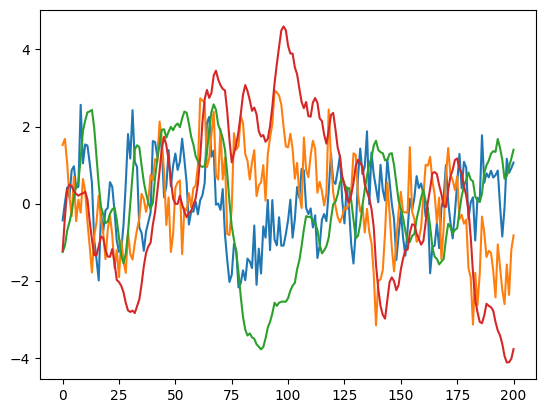

In [168]:
# --- 2次元線形モデルの定義 (前回と同様) ---
x_s0, x_s1 = symbols("x_0, x_1")
y_s0, y_s1 = symbols("y_0, y_1")
th1_0, th1_1 = symbols("theta_10, theta_11")
th2_0, th2_1, th2_2, th2_3 = symbols("theta_20, theta_21, theta_22, theta_23")
th3_0, th3_1, th3_2, th3_3 = symbols("theta_30, theta_31, theta_32, theta_33")

x_sym_2d = Array([x_s0, x_s1])
y_sym_2d = Array([y_s0, y_s1])
theta_1_sym_2d = Array([th1_0, th1_1])
theta_2_sym_2d = Array([th2_0, th2_1, th2_2, th2_3])
theta_3_sym_2d = Array([th3_0, th3_1, th3_2, th3_3])

A_expr_2d = Array([-th2_0 * x_s0 - th2_1 * x_s1, -th2_2 * x_s0 - th2_3 * x_s1])
B_expr_2d = Array([[th1_0, 0], [0, th1_1]])
H_expr_2d = Array([th3_0 * x_s0 - th3_1 * y_s0, th3_2 * x_s1 - th3_3 * y_s1])

linear_model_2d = DegenerateDiffusionProcess(
    x=x_sym_2d, y=y_sym_2d, theta_1=theta_1_sym_2d, theta_2=theta_2_sym_2d,
    theta_3=theta_3_sym_2d, A=A_expr_2d, B=B_expr_2d, H=H_expr_2d
)
likelihood_linear_2d = LikelihoodEvaluator(linear_model_2d) # 警告が出ていないことを確認済みと仮定

x_series_2d, y_series_2d = linear_model_2d.simulate(
    true_theta=(true_theta1_val_2d, true_theta2_val_2d, true_theta3_val_2d),
    t_max=t_max,
    h=h_obs,
    burn_out=burn_out,
    seed=seed_val,
    x0=np.array([0.1, 0.1]), # 2次元の初期値
    y0=np.array([-0.1, 0.1]), # 2次元の初期値
    dt=dt,
)
plt.plot(x_series_2d[:, 0], label="x series")
plt.plot(x_series_2d[:, 1], label="y series")
plt.plot(y_series_2d[:, 0], label="y series")
plt.plot(y_series_2d[:, 1], label="y series")
plt.show()

Generating a single dataset for diagnostics...
Generated x_series_diag shape: (1001, 2), y_series_diag shape: (1001, 2)

--- Objective function values at specific theta_1 points ---
Objective value at True Value ([1.  1.2]): -0.4345073351646064
Objective value at Initial Guess (from opt) ([0.8 1. ]): -0.23566406223932768
Objective value at Problematic Result (Simulated) ([1.       1.999999]): -0.05676418202305601
Objective value at Near True (th1_1 lower) ([1.  1.1]): -0.417286913762497
Objective value at Near True (th1_1 higher) ([1.  1.3]): -0.4232540797168485
Objective value at Lower Bound (th1_1) ([1.    0.001]): 1448776.1565574883

Plotting objective function for V1 (theta_1)...


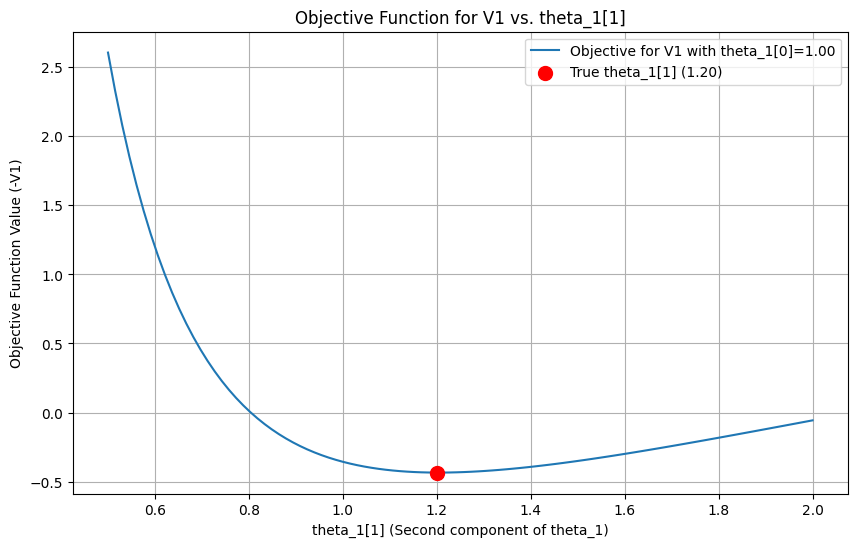

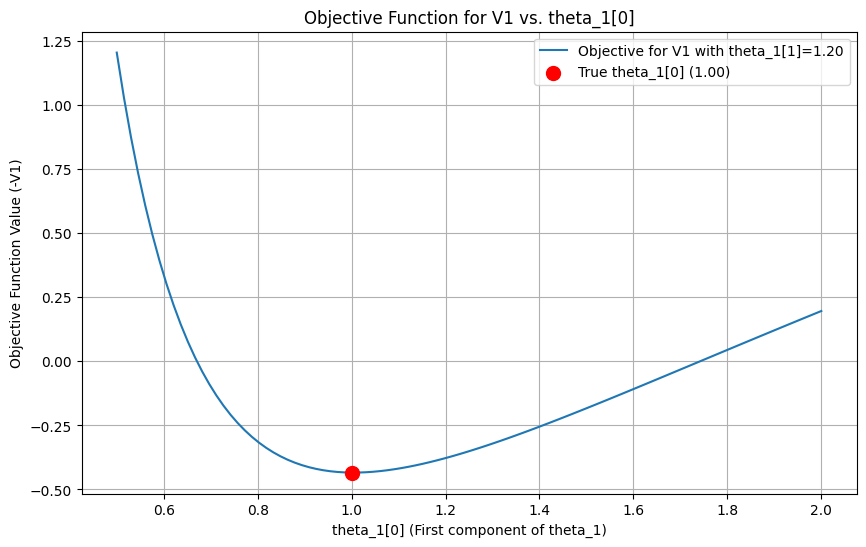


--- Guidance for further debugging based on plots and values ---
1. Check the plot for theta_1[1]:
   - Does it have a minimum near the true value (1.2)?
   - Or does it decrease monotonically towards the boundary (2.0)?
   - Are there NaNs or extreme values in the plot?
2. Check the objective values at specific points:
   - The value at 'True Value' should ideally be the lowest.
   - Compare with the value at 'Problematic Result'. Is it indeed lower?
3. If the plot looks problematic (e.g., minimum at boundary, NaNs):
   - Add detailed print statements *inside your LikelihoodEvaluator.evaluate_v1* method.
     Specifically, for a few `j_idx` (e.g., j_idx=1, 2, and a later one), print:
     - `x_j_1`, `y_j_1`
     - `theta_1_val` (the one passed to evaluate_v1)
     - `inv_S0_xx_val`, `inv_S0_xy_val`, `inv_S0_yx_val`, `inv_S0_yy_val`
     - `log_det_S0_val`
     - `Dx_val`, `Dy_val`
     - `sum_S_xx`, `sum_S_xy`, `sum_S_yx`, `sum_S_yy` (after the loop)
     - `q_xx`, `q_xy`, `q_yx`, `q

In [169]:
import sympy as sp
from sympy import Array, symbols
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt # プロット用
from typing import Tuple, Optional, Sequence, Dict, Callable, Any # 型ヒント用

# ==============================================================================
# ここに DegenerateDiffusionProcess クラスと LikelihoodEvaluator クラスの
# 正しい定義が記述されているものとします。
# (ユーザー様がこれまでのやり取りで完成させたバージョンを想定)
# from your_module import DegenerateDiffusionProcess, LikelihoodEvaluator
# ==============================================================================

# --- 2次元線形モデルの定義 (前回と同様) ---
x_s0, x_s1 = symbols("x_0, x_1")
y_s0, y_s1 = symbols("y_0, y_1")
th1_0, th1_1 = symbols("theta_10, theta_11")
th2_0, th2_1, th2_2, th2_3 = symbols("theta_20, theta_21, theta_22, theta_23")
th3_0, th3_1, th3_2, th3_3 = symbols("theta_30, theta_31, theta_32, theta_33")

x_sym_2d = Array([x_s0, x_s1])
y_sym_2d = Array([y_s0, y_s1])
theta_1_sym_2d = Array([th1_0, th1_1])
theta_2_sym_2d = Array([th2_0, th2_1, th2_2, th2_3])
theta_3_sym_2d = Array([th3_0, th3_1, th3_2, th3_3])

A_expr_2d = Array([-th2_0 * x_s0 - th2_1 * x_s1, -th2_2 * x_s0 - th2_3 * x_s1])
B_expr_2d = Array([[th1_0, 0], [0, th1_1]])
H_expr_2d = Array([th3_0 * x_s0 - th3_1 * y_s0, th3_2 * x_s1 - th3_3 * y_s1])

linear_model_2d = DegenerateDiffusionProcess(
    x=x_sym_2d, y=y_sym_2d, theta_1=theta_1_sym_2d, theta_2=theta_2_sym_2d,
    theta_3=theta_3_sym_2d, A=A_expr_2d, B=B_expr_2d, H=H_expr_2d
)
likelihood_linear_2d = LikelihoodEvaluator(linear_model_2d) # 警告が出ていないことを確認済みと仮定

# --- シミュレーションパラメータ (前回と同様) ---
t_max = 100.0
burn_out = 50.0
dt = 0.01
h_obs = 0.1
k_expansion = 3 # V1の展開次数k

true_theta1_val_2d = np.array([1.0, 1.2])
true_theta2_val_2d = np.array([0.5, 0.1, 0.2, 0.6])
true_theta3_val_2d = np.array([0.8, 0.3, 0.9, 0.4])

bar_theta1_2d = true_theta1_val_2d
bar_theta2_2d = true_theta2_val_2d
bar_theta3_2d = true_theta3_val_2d

# --- 単一のデータセット生成 ---
print("Generating a single dataset for diagnostics...")
x_series_diag, y_series_diag = linear_model_2d.simulate(
    true_theta=(true_theta1_val_2d, true_theta2_val_2d, true_theta3_val_2d),
    t_max=t_max, h=h_obs, burn_out=burn_out, seed=42, # 固定シードで再現性確保
    x0=np.array([0.1, -0.1]), y0=np.array([-0.1, 0.1]), dt=dt,
)
print(f"Generated x_series_diag shape: {x_series_diag.shape}, y_series_diag shape: {y_series_diag.shape}")

# --- V1の評価関数と目的関数の準備 ---
try:
    v1_eval_func_diag = likelihood_linear_2d.make_quasi_likelihood_v1_evaluator(
        x_series=x_series_diag, y_series=y_series_diag, h=h_obs, k=k_expansion,
    )
except RuntimeError as e:
    print(f"Error creating V1 evaluator: {e}")
    print("This indicates that S0-related symbolic functions might still be None.")
    print("Please double-check the LikelihoodEvaluator.__init__ method for any warnings or errors during symbolic computation for this 2D model.")
    # プロットや以降の評価に進めないためここで終了
    exit()


def objective_v1_diag(theta_1_val_opt):
    # theta_1_val_opt は scipy.optimize.minimize から渡される形式 (1D numpy array)
    # bar パラメータは上で定義したものを使用
    return -v1_eval_func_diag(
        theta_1_val=theta_1_val_opt, # 最適化対象
        theta_1_bar=bar_theta1_2d,   # 固定
        theta_2_bar=bar_theta2_2d,   # 固定
        theta_3_bar=bar_theta3_2d,   # 固定
    )

# --- 特定のtheta_1での目的関数値の評価 ---
theta1_points_to_check = {
    "True Value": true_theta1_val_2d,
    "Initial Guess (from opt)": np.array([0.8, 1.0]),
    "Problematic Result (Simulated)": np.array([1.0, 2.0-1e-6]), # 境界値そのものではなく少し内側
    "Near True (th1_1 lower)": np.array([1.0, 1.1]),
    "Near True (th1_1 higher)": np.array([1.0, 1.3]),
    "Lower Bound (th1_1)": np.array([1.0, 1e-3]),
}

print("\n--- Objective function values at specific theta_1 points ---")
for name, th1_test_val in theta1_points_to_check.items():
    try:
        obj_val = objective_v1_diag(th1_test_val)
        print(f"Objective value at {name} ({th1_test_val}): {obj_val}")
    except Exception as e:
        print(f"Error evaluating objective at {name} ({th1_test_val}): {e}")

# --- 目的関数のプロット ---
print("\nPlotting objective function for V1 (theta_1)...")

# 1. theta_1[0] を真値 (1.0) に固定し、theta_1[1] を変化させる
theta1_0_fixed = true_theta1_val_2d[0]
theta1_1_range = np.linspace(0.5, 2.0, 100) # 境界内で100点
obj_values_th1_1_varying = []

for th1_1_val in theta1_1_range:
    current_theta1 = np.array([theta1_0_fixed, th1_1_val])
    try:
        obj_values_th1_1_varying.append(objective_v1_diag(current_theta1))
    except Exception as e:
        # print(f"Error plotting for theta_1 = {current_theta1}: {e}") #詳細すぎる場合がある
        obj_values_th1_1_varying.append(np.nan) # エラー時はNaN

plt.figure(figsize=(10, 6))
plt.plot(theta1_1_range, obj_values_th1_1_varying, label=f'Objective for V1 with theta_1[0]={theta1_0_fixed:.2f}')
plt.scatter([true_theta1_val_2d[1]], [objective_v1_diag(true_theta1_val_2d) if 'v1_eval_func_diag' in locals() else np.nan], color='red', s=100, zorder=5, label=f'True theta_1[1] ({true_theta1_val_2d[1]:.2f})')
plt.xlabel("theta_1[1] (Second component of theta_1)")
plt.ylabel("Objective Function Value (-V1)")
plt.title("Objective Function for V1 vs. theta_1[1]")
plt.legend()
plt.grid(True)
plt.show()

# 2. theta_1[1] を真値 (1.2) に固定し、theta_1[0] を変化させる (オプション)
theta1_1_fixed = true_theta1_val_2d[1]
theta1_0_range = np.linspace(0.5, 2.0, 100)
obj_values_th1_0_varying = []

for th1_0_val in theta1_0_range:
    current_theta1 = np.array([th1_0_val, theta1_1_fixed])
    try:
        obj_values_th1_0_varying.append(objective_v1_diag(current_theta1))
    except Exception as e:
        obj_values_th1_0_varying.append(np.nan)

plt.figure(figsize=(10, 6))
plt.plot(theta1_0_range, obj_values_th1_0_varying, label=f'Objective for V1 with theta_1[1]={theta1_1_fixed:.2f}')
plt.scatter([true_theta1_val_2d[0]], [objective_v1_diag(true_theta1_val_2d) if 'v1_eval_func_diag' in locals() else np.nan], color='red', s=100, zorder=5, label=f'True theta_1[0] ({true_theta1_val_2d[0]:.2f})')
plt.xlabel("theta_1[0] (First component of theta_1)")
plt.ylabel("Objective Function Value (-V1)")
plt.title("Objective Function for V1 vs. theta_1[0]")
plt.legend()
plt.grid(True)
plt.show()

print("\n--- Guidance for further debugging based on plots and values ---")
print("1. Check the plot for theta_1[1]:")
print("   - Does it have a minimum near the true value (1.2)?")
print("   - Or does it decrease monotonically towards the boundary (2.0)?")
print("   - Are there NaNs or extreme values in the plot?")
print("2. Check the objective values at specific points:")
print("   - The value at 'True Value' should ideally be the lowest.")
print("   - Compare with the value at 'Problematic Result'. Is it indeed lower?")
print("3. If the plot looks problematic (e.g., minimum at boundary, NaNs):")
print("   - Add detailed print statements *inside your LikelihoodEvaluator.evaluate_v1* method.")
print("     Specifically, for a few `j_idx` (e.g., j_idx=1, 2, and a later one), print:")
print("     - `x_j_1`, `y_j_1`")
print("     - `theta_1_val` (the one passed to evaluate_v1)")
print("     - `inv_S0_xx_val`, `inv_S0_xy_val`, `inv_S0_yx_val`, `inv_S0_yy_val`")
print("     - `log_det_S0_val`")
print("     - `Dx_val`, `Dy_val`")
print("     - `sum_S_xx`, `sum_S_xy`, `sum_S_yx`, `sum_S_yy` (after the loop)")
print("     - `q_xx`, `q_xy`, `q_yx`, `q_yy`")
print("     - `tr_xx`, `tr_xy`, `tr_yx`, `tr_yy`")
print("     - `quadratic_term`, `trace_term`, `logdet_term`")
print("     - `step_likelihood`")
print("   - Run this printing for `theta_1_val_opt` set to the true value, and then for values near the problematic boundary (e.g., [1.0, 1.9], [1.0, 1.99]).")
print("   - Look for NaNs, Infs, very large numbers, or unexpected signs in these intermediate values.")
print("4. Verify symbolic expressions for S0-related terms specifically for this 2D linear model, as discussed previously.")
print("   Ensure they simplify to the expected (often diagonal) forms.")


--- V1 PRIME Objective function values at specific theta_1 points ---
Objective value (V1') at True Value ([1.  1.2]): 1.1645542024625568
Objective value (V1') at Initial Guess (from opt) ([0.8 1. ]): 1.2484356955195408
Objective value (V1') at Problematic Result (Simulated) ([1.       1.999999]): 1.3454045918802633
Objective value (V1') at Near True (th1_1 lower) ([1.  1.1]): 1.175546740233534
Objective value (V1') at Near True (th1_1 higher) ([1.  1.3]): 1.1683268195390166
Objective value (V1') at Lower Bound (th1_1) ([1.    0.001]): 742437.1287997331

Plotting objective function for V1' (theta_1)...


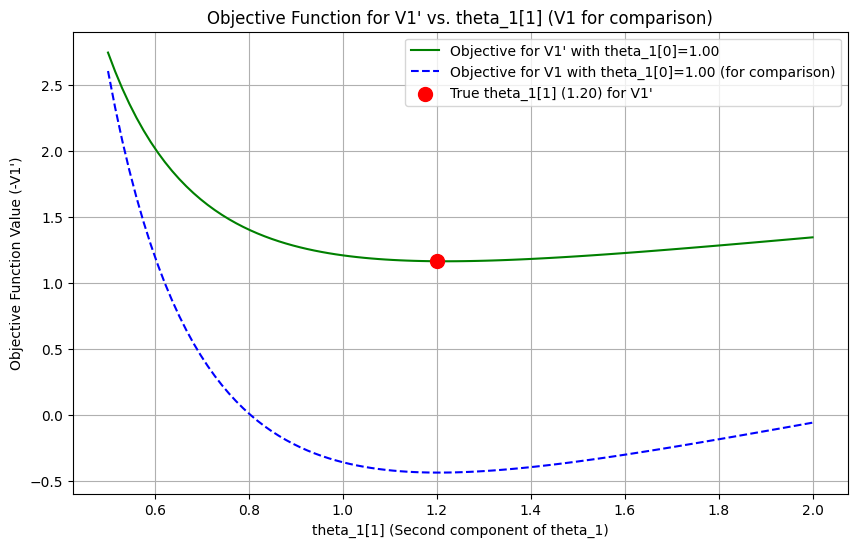

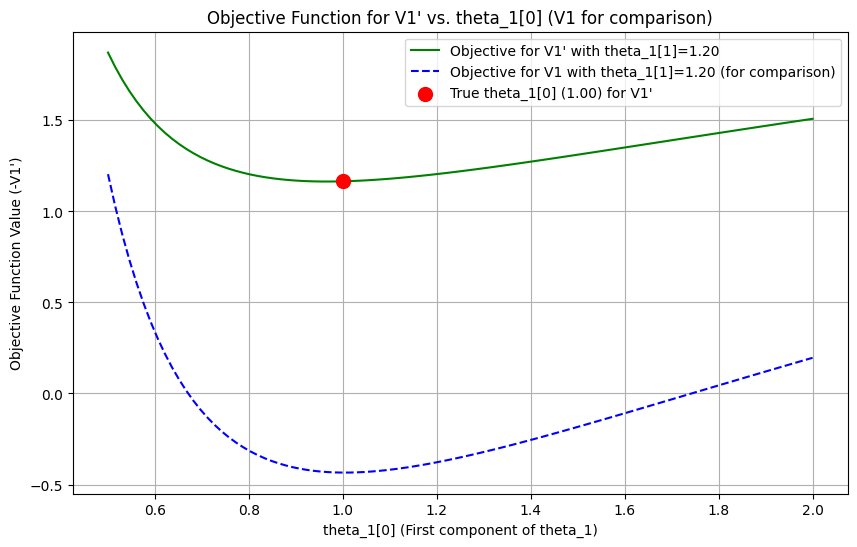

In [170]:
# [前回のコードの続き、または必要な部分を再掲]

# --- V1プライムの評価関数と目的関数の準備 ---
try:
    v1_prime_eval_func_diag = likelihood_linear_2d.make_quasi_likelihood_v1_prime_evaluator(
        x_series=x_series_diag, y_series=y_series_diag, h=h_obs, k=k_expansion,
    )
except RuntimeError as e:
    print(f"Error creating V1' evaluator: {e}")
    # V1'の評価に進めないため、関連処理をスキップ
    v1_prime_eval_func_diag = None # 後続の処理でNoneチェックを行う


def objective_v1_prime_diag(theta_1_val_opt):
    if v1_prime_eval_func_diag is None:
        return np.nan # エラー時はNaNを返す
    return -v1_prime_eval_func_diag(
        theta_1_val=theta_1_val_opt,
        theta_1_bar=bar_theta1_2d,
        theta_2_bar=bar_theta2_2d,
        theta_3_bar=bar_theta3_2d,
    )

# --- 特定のtheta_1での V1プライム の目的関数値の評価 ---
print("\n--- V1 PRIME Objective function values at specific theta_1 points ---")
if v1_prime_eval_func_diag is not None:
    for name, th1_test_val in theta1_points_to_check.items(): # theta1_points_to_checkは前回定義済みと仮定
        try:
            obj_val = objective_v1_prime_diag(th1_test_val)
            print(f"Objective value (V1') at {name} ({th1_test_val}): {obj_val}")
        except Exception as e:
            print(f"Error evaluating objective (V1') at {name} ({th1_test_val}): {e}")
else:
    print("V1' evaluator not available, skipping evaluations.")


# --- V1プライムの目的関数のプロット ---
print("\nPlotting objective function for V1' (theta_1)...")

if v1_prime_eval_func_diag is not None:
    # 1. theta_1[0] を真値 (1.0) に固定し、theta_1[1] を変化させる (V1プライム用)
    theta1_0_fixed_v1p = true_theta1_val_2d[0]
    # theta1_1_range は前回定義済み (np.linspace(1e-3, 2.0, 100))
    obj_values_th1_1_varying_v1p = []

    for th1_1_val in theta1_1_range:
        current_theta1 = np.array([theta1_0_fixed_v1p, th1_1_val])
        try:
            obj_values_th1_1_varying_v1p.append(objective_v1_prime_diag(current_theta1))
        except Exception as e:
            obj_values_th1_1_varying_v1p.append(np.nan)

    plt.figure(figsize=(10, 6))
    plt.plot(theta1_1_range, obj_values_th1_1_varying_v1p, label=f"Objective for V1' with theta_1[0]={theta1_0_fixed_v1p:.2f}", color='green')
    # V1のプロットも重ねて描画する場合 (obj_values_th1_1_varying は前回計算済みと仮定)
    if 'obj_values_th1_1_varying' in locals() and obj_values_th1_1_varying:
         plt.plot(theta1_1_range, obj_values_th1_1_varying, label=f'Objective for V1 with theta_1[0]={theta1_0_fixed_v1p:.2f} (for comparison)', color='blue', linestyle='--')

    plt.scatter([true_theta1_val_2d[1]], [objective_v1_prime_diag(true_theta1_val_2d)], color='red', s=100, zorder=5, label=f'True theta_1[1] ({true_theta1_val_2d[1]:.2f}) for V1\'')
    plt.xlabel("theta_1[1] (Second component of theta_1)")
    plt.ylabel("Objective Function Value (-V1')")
    plt.title("Objective Function for V1' vs. theta_1[1] (V1 for comparison)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. theta_1[1] を真値 (1.2) に固定し、theta_1[0] を変化させる (V1プライム用)
    theta1_1_fixed_v1p = true_theta1_val_2d[1]
    # theta1_0_range は前回定義済み (np.linspace(1e-3, 2.0, 100))
    obj_values_th1_0_varying_v1p = []

    for th1_0_val in theta1_0_range:
        current_theta1 = np.array([th1_0_val, theta1_1_fixed_v1p])
        try:
            obj_values_th1_0_varying_v1p.append(objective_v1_prime_diag(current_theta1))
        except Exception as e:
            obj_values_th1_0_varying_v1p.append(np.nan)

    plt.figure(figsize=(10, 6))
    plt.plot(theta1_0_range, obj_values_th1_0_varying_v1p, label=f"Objective for V1' with theta_1[1]={theta1_1_fixed_v1p:.2f}", color='green')
    # V1のプロットも重ねて描画する場合 (obj_values_th1_0_varying は前回計算済みと仮定)
    if 'obj_values_th1_0_varying' in locals() and obj_values_th1_0_varying:
        plt.plot(theta1_0_range, obj_values_th1_0_varying, label=f'Objective for V1 with theta_1[1]={theta1_1_fixed_v1p:.2f} (for comparison)', color='blue', linestyle='--')

    plt.scatter([true_theta1_val_2d[0]], [objective_v1_prime_diag(true_theta1_val_2d)], color='red', s=100, zorder=5, label=f'True theta_1[0] ({true_theta1_val_2d[0]:.2f}) for V1\'')
    plt.xlabel("theta_1[0] (First component of theta_1)")
    plt.ylabel("Objective Function Value (-V1')")
    plt.title("Objective Function for V1' vs. theta_1[0] (V1 for comparison)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("V1' evaluator was not created successfully. Skipping V1' plots.")

In [137]:
from scipy import optimize # optimizeをインポート
x_sym, y_sym_1,y_sym_2 = symbols("x, y_1, y_2")
theta_10, theta_20, theta_21 = symbols("theta_10 theta_20 theta_21")
theta_30= symbols("theta_30")

# ベクトル化（1次元テンソルとして）
x = Array([x_sym])
y = Array([y_sym_1,y_sym_2])
theta_1 = Array([theta_10])
theta_2 = Array([theta_20, theta_21])
theta_3 = Array([theta_30])

# Step 2: A, B, H の式定義
A = Array([-theta_20 * x_sym -theta_21 * y_sym_1]) 
B = Array([[theta_10]])
H = Array([theta_30 * x_sym, -y_sym_1  - y_sym_2])


# インスタンス
Linearmodel = DegenerateDiffusionProcess(
    x=x,
    y=y,
    theta_1=theta_1,
    theta_2=theta_2,
    theta_3=theta_3,
    A=A,
    B=B,
    H=H,
)

Likelihood_Linear = LikelihoodEvaluator(Linearmodel)


# Step 3: 評価関数の作成

# 最適化結果を格納するリスト
estimated_theta1_v1_prime_list = []
estimated_theta1_v1_list = []
estimated_theta2_list = []
estimated_theta3_list = []

# シミュレーションの回数
num_simulations = 100 # 例として10回

# 固定する bar パラメータ (真値を使用)
# scipy.optimize.minimize に渡す関数内で使うため、numpy 配列にしておくと扱いやすい
true_theta1_bar = np.array([1])
true_theta2_bar = np.array([1, 1])
true_theta3_bar = np.array([1])
t_max = 100.0
burn_out = 50.0
dt = 0.01
h = 0.5
k = 3
for seed_val in range(num_simulations):
    print(f"\n--- Simulation and Optimization for Seed: {seed_val} ---")
    # シミュレーションの実行
    x_series, y_series = Linearmodel.simulate(
        true_theta=([1], [1, 1], [1]), # (theta_1, theta_2, theta_3)
        t_max=t_max,
        h=h,
        burn_out=burn_out,
        seed=seed_val,
        x0=None,
        y0=None,
        dt=dt,
    )

    # 各尤度評価関数を生成
    # (これらの make_..._evaluator 関数は、x_series, y_series などにクロージャでアクセスする関数を返す)
    v1_prime_eval_func = Likelihood_Linear.make_quasi_likelihood_v1_prime_evaluator(
        x_series=x_series, y_series=y_series, h=h, k=k,
    )
    v1_eval_func = Likelihood_Linear.make_quasi_likelihood_v1_evaluator(
        x_series=x_series, y_series=y_series, h=h, k=k,
    )
    v2_eval_func = Likelihood_Linear.make_quasi_likelihood_v2_evaluator(
        x_series=x_series, y_series=y_series, h=h, k=k,
    )
    v3_eval_func = Likelihood_Linear.make_quasi_likelihood_v3_evaluator(
        x_series=x_series, y_series=y_series, h=h, k=k,
    )

    # --- 最適化のための目的関数定義 (負の対数尤度を最小化) ---
    # scipy.optimize.minimize は numpy 配列を引数として渡す
    def objective_v1_prime(theta_1_val_opt):
        # theta_1_val_opt は minimize から渡される numpy 配列
        return -v1_prime_eval_func(
            theta_1_val=theta_1_val_opt,
            theta_1_bar=true_theta1_bar,
            theta_2_bar=true_theta2_bar,
            theta_3_bar=true_theta3_bar,
        )

    def objective_v1(theta_1_val_opt):
        return -v1_eval_func(
            theta_1_val=theta_1_val_opt,
            theta_1_bar=true_theta1_bar,
            theta_2_bar=true_theta2_bar,
            theta_3_bar=true_theta3_bar,
        )

    def objective_v2(theta_2_val_opt):
        return -v2_eval_func(
            theta_2_val=theta_2_val_opt,
            theta_1_bar=true_theta1_bar,
            theta_2_bar=true_theta2_bar, # v2では theta_2_bar は使われるが、最適化対象は theta_2_val
            theta_3_bar=true_theta3_bar,
        )

    def objective_v3(theta_3_val_opt):
        return -v3_eval_func(
            theta_3_val=theta_3_val_opt,
            theta_1_bar=true_theta1_bar,
            theta_2_bar=true_theta2_bar,
            theta_3_bar=true_theta3_bar, # v3では theta_3_bar は使われるが、最適化対象は theta_3_val
        )

    # --- 最適化の実行 ---
    # 初期値と境界 (真値を参考に適当に設定)
    x0_theta1 = np.array([0.3]) # 真値 [0.3]
    bounds_theta1 = [(1e-3, 2.0)] # theta_10 > 0 を想定

    x0_theta2 = np.array([1.5, 0.8]) # 真値 [1.5, 0.8]
    bounds_theta2 = [(0.1, 3.0), (0.0, 2.0)]

    x0_theta3 = np.array([0.1]) # 真値 [0.1, 0.0]
    bounds_theta3 = [(1e-3, 2)] # theta_30 > 0 を想定

    print(f"Optimizing for seed {seed_val}...")
    try:
        res_v1_prime = optimize.minimize(objective_v1_prime, x0=x0_theta1, method="L-BFGS-B", bounds=bounds_theta1)
        if res_v1_prime.success:
            estimated_theta1_v1_prime_list.append(res_v1_prime.x)
            print(f"  V1' optimized theta_1: {res_v1_prime.x}")
        else:
            estimated_theta1_v1_prime_list.append(np.full_like(x0_theta1, np.nan))
            print(f"  V1' optimization FAILED: {res_v1_prime.message}")
    except Exception as e:
        estimated_theta1_v1_prime_list.append(np.full_like(x0_theta1, np.nan))
        print(f"  Error during V1' optimization: {e}")

    try:
        res_v1 = optimize.minimize(objective_v1, x0=x0_theta1, method="L-BFGS-B", bounds=bounds_theta1)
        if res_v1.success:
            estimated_theta1_v1_list.append(res_v1.x)
            print(f"  V1  optimized theta_1: {res_v1.x}")
        else:
            estimated_theta1_v1_list.append(np.full_like(x0_theta1, np.nan))
            print(f"  V1  optimization FAILED: {res_v1.message}")
    except Exception as e:
        estimated_theta1_v1_list.append(np.full_like(x0_theta1, np.nan))
        print(f"  Error during V1 optimization: {e}")

    try:
        res_v2 = optimize.minimize(objective_v2, x0=x0_theta2, method="L-BFGS-B", bounds=bounds_theta2)
        if res_v2.success:
            estimated_theta2_list.append(res_v2.x)
            print(f"  V2  optimized theta_2: {res_v2.x}")
        else:
            estimated_theta2_list.append(np.full_like(x0_theta2, np.nan))
            print(f"  V2  optimization FAILED: {res_v2.message}")
    except Exception as e:
        estimated_theta2_list.append(np.full_like(x0_theta2, np.nan))
        print(f"  Error during V2 optimization: {e}")

    try:
        res_v3 = optimize.minimize(objective_v3, x0=x0_theta3, method="L-BFGS-B", bounds=bounds_theta3)
        if res_v3.success:
            estimated_theta3_list.append(res_v3.x)
            print(f"  V3  optimized theta_3: {res_v3.x}")
        else:
            estimated_theta3_list.append(np.full_like(x0_theta3, np.nan))
            print(f"  V3  optimization FAILED: {res_v3.message}")
    except Exception as e:
        estimated_theta3_list.append(np.full_like(x0_theta3, np.nan))
        print(f"  Error during V3 optimization: {e}")

# ループ終了後、結果の確認
print("\n--- Optimization Results Summary ---")
print(f"Estimated theta_1 (V1'):")
for i, est_th1 in enumerate(estimated_theta1_v1_prime_list):
    print(f"  Seed {i}: {est_th1}")

print(f"\nEstimated theta_1 (V1):")
for i, est_th1 in enumerate(estimated_theta1_v1_list):
    print(f"  Seed {i}: {est_th1}")

print(f"\nEstimated theta_2 (V2):")
for i, est_th2 in enumerate(estimated_theta2_list):
    print(f"  Seed {i}: {est_th2}")

print(f"\nEstimated theta_3 (V3):")
for i, est_th3 in enumerate(estimated_theta3_list):
    print(f"  Seed {i}: {est_th3}")


--- Simulation and Optimization for Seed: 0 ---


RuntimeError: S0 related functions ['inv_S0_xx_func', 'inv_S0_xy_func', 'inv_S0_yx_func', 'inv_S0_yy_func', 'log_det_S0_func'] are missing for V1. Check __init__ warnings.

In [150]:
# -*- coding: utf-8 -*-
import sympy as sp
from sympy import (Array, symbols, factorial, tensorproduct, log, det, Matrix,
                   Expr, Basic, S, zeros, srepr, oo) # oo (Infinity) をインポート (未使用だが sympy の一部)
# NonInvertibleMatrixError を正しくインポート
from sympy.matrices.common import NonInvertibleMatrixError
from sympy.tensor.array import derive_by_array
from einsum_sympy import einsum_sympy
from sympy.utilities.lambdify import lambdify
import numpy as np
from numpy import einsum, power, isfinite, nan # numpy 関数を明示的にインポート
from typing import TYPE_CHECKING, Dict, Callable, Tuple, Any, Optional

# # --- 前提クラス (型ヒント用) ---
# if TYPE_CHECKING:
#     from typing import Type
#     DegenerateDiffusionProcess = Type['DegenerateDiffusionProcess']
# else:
#     # 実行時に必要ない場合はプレースホルダーで十分
#     class DegenerateDiffusionProcess: pass

# --- 定数 ---
INVALID_SREPR_KEY = "invalid_sympy_srepr"

class LikelihoodEvaluator:
    """
    DegenerateDiffusionProcess モデルに基づき疑似尤度を計算するクラス (詳細省略)。
    """

    def __init__(self, model: 'DegenerateDiffusionProcess'):
        """ LikelihoodEvaluator のインスタンスを初期化 """
        # isinstance チェックは、model の完全な定義が見える場所 (呼び出し元など) で行うことを推奨
        # if not isinstance(model, DegenerateDiffusionProcess):
        #     raise TypeError("model must be an instance of DegenerateDiffusionProcess")

        self.model = model
        self._L_cache: Dict[Tuple[int, str], Array] = {}
        self._L0_func_cache: Dict[Tuple[int, str], Callable] = {}
        self._S_func_cache: Dict[int, Tuple[Callable, ...]] = {}

        # --- モデル属性への参照 (1行1文に修正) ---
        self.x = model.x
        self.y = model.y
        self.theta_1 = model.theta_1
        self.theta_2 = model.theta_2
        self.theta_3 = model.theta_3
        self.A = model.A
        self.B = model.B
        self.H = model.H

        # --- モデルから lambdify 済み関数を取得 ---
        required_funcs = ['A_func', 'B_func', 'H_func']
        if not all(hasattr(model, func_name) and callable(getattr(model, func_name)) for func_name in required_funcs):
             missing = [f for f in required_funcs if not hasattr(model, f) or not callable(getattr(model, f))]
             raise AttributeError(f"Provided model instance is missing required callable functions: {missing}")
        self.A_func = model.A_func
        self.B_func = model.B_func
        self.H_func = model.H_func
        common_args = (self.x, self.y)

        # --- 派生的な記号計算と lambdify ---
        try:
            # C = B B^T
            C_sym = einsum_sympy("ik,jk->ij", self.B, self.B)
            self.C = C_sym
            self.C_func = lambdify((*common_args, self.theta_1), C_sym, modules="numpy")

            # inv(C), log(det(C))
            C_matrix = Matrix(C_sym)
            inv_C_expr = None # スコープのために初期化
            try:
                inv_C_expr = Array(C_matrix.inv())
                self.inv_C_func = lambdify((*common_args, self.theta_1), inv_C_expr, modules="numpy")
            except NonInvertibleMatrixError:
                print("Warning: Symbolic matrix C is not invertible. inv_C_func=None.")
                self.inv_C_func = None
            try:
                det_C = C_matrix.det()
                # det <= 0 の場合 log で ValueError が発生する
                if det_C.is_nonpositive:
                     print("Warning: Symbolic det(C) is non-positive. log_det_C_func=None.")
                     self.log_det_C_func = None
                elif det_C == 0:
                     print("Warning: Symbolic det(C) is zero. log_det_C_func=-oo (set to None).")
                     self.log_det_C_func = None # -infinity は扱いにくいので None
                else:
                     log_det_C_expr = log(det_C)
                     self.log_det_C_func = lambdify((*common_args, self.theta_1), log_det_C_expr, modules="numpy")
            except Exception as e: # その他のエラー (例: SymPy の is_nonpositive が判定不能)
                 print(f"Warning: Could not reliably determine sign of det(C) or log failed ({e}). log_det_C_func=None.")
                 self.log_det_C_func = None

            # dH/dx
            partial_x_H_sym = derive_by_array(self.H, self.x)
            self.partial_x_H = partial_x_H_sym

            # V = (dH/dx) C (dH/dx)^T
            V_sym = einsum_sympy("ki,kl,lj->ij", partial_x_H_sym, C_sym, partial_x_H_sym)
            self.V = V_sym
            self.V_func = lambdify((*common_args, self.theta_1, self.theta_3), V_sym, modules="numpy")

            # inv(V)
            V_matrix = Matrix(V_sym)
            inv_V_expr = None # スコープのために初期化
            try:
                inv_V_expr = Array(V_matrix.inv())
                self.inv_V_func = lambdify((*common_args, self.theta_1, self.theta_3), inv_V_expr, modules="numpy")
            except NonInvertibleMatrixError:
                print("Warning: Symbolic matrix V is not invertible. inv_V_func=None.")
                self.inv_V_func = None
            except Exception as e:
                print(f"Warning: Error inverting V matrix: {e}")
                self.inv_V_func = None
            try:
                log_det_V_expr = log(V_matrix.det())
                self.log_det_V_func = lambdify(
                    (*common_args, self.theta_1, self.theta_3),
                    log_det_V_expr, modules="numpy"
                )
            except Exception as e:
                print(f"Warning: Error calculating log(det(V)): {e}")
                self.log_det_V_func = None
            

            # (dH/dx)^T inv(V)
            # inv_V_func と inv_V_expr が計算できた場合のみ
            if self.inv_V_func is not None and inv_V_expr is not None:
                partial_x_H_transpose_inv_V_expr = einsum_sympy("ij,jk->ik", partial_x_H_sym, inv_V_expr)
                self.partial_x_H_transpose_inv_V_func = lambdify(
                    (*common_args, self.theta_1, self.theta_3),
                    partial_x_H_transpose_inv_V_expr, modules="numpy"
                )
            else:
                 self.partial_x_H_transpose_inv_V_func = None

            # inv_S0_xx, inv_S0_xy, inv_S0_yx, inv_S0_yyを計算する
            if inv_C_expr is not None and inv_V_expr is not None and partial_x_H_transpose_inv_V_expr is not None:
                try:
                    inv_S0_xx_expr = inv_C_expr + 3* einsum_sympy('ij,kj->ik',partial_x_H_transpose_inv_V_expr,self.partial_x_H)
                    self.inv_S0_xx_func = lambdify(
                        (*common_args, self.theta_1, self.theta_3),
                        inv_S0_xx_expr, modules="numpy"
                    )
                except Exception as e:
                    print(f"Error creating inv_S0_xx_func: {e}")
                try:
                    inv_S0_xy_expr = - 6*partial_x_H_transpose_inv_V_expr
                    self.inv_S0_xy_func = lambdify(
                        (*common_args, self.theta_1, self.theta_3),
                        inv_S0_xy_expr, modules="numpy"
                    )
                except Exception as e:
                    print(f"Error creating inv_S0_xy_func: {e}")
                try:
                    inv_S0_yx_expr = sp.transpose(Matrix(inv_S0_xy_expr))
                    inv_S0_yx_expr = Array(inv_S0_yx_expr)
                    self.inv_S0_yx_func = lambdify(
                        (*common_args, self.theta_1, self.theta_3),
                        inv_S0_yx_expr, modules="numpy"
                    )
                except Exception as e:
                    print(f"Error creating inv_S0_yx_func: {e}")
                try:
                    inv_S0_yy_expr = 12*inv_V_expr
                    self.inv_S0_yy_func = lambdify(
                        (*common_args, self.theta_1, self.theta_3),
                        inv_S0_yy_expr, modules="numpy"
                    )
                except Exception as e:
                    print(f"Error creating inv_S0_yy_func: {e}")
            else:
                print("Warning: Could not create inv_S0_xx, inv_S0_xy, inv_S0_yx, inv_S0_yy functions due to previous errors.")
                self.inv_S0_xx_func = None
                self.inv_S0_xy_func = None
                self.inv_S0_yx_func = None
                self.inv_S0_yy_func = None
            
            # log_det_S0の計算
            if self.log_det_C_func is not None and self.log_det_V_func is not None:
                try:
                    d_y = self.y.shape[0]
                    log_det_S0_expr = log_det_C_expr + log_det_V_expr + d_y * sp.log(sp.S(1)/12)
                    self.log_det_S0_func = lambdify(
                        (*common_args, self.theta_1, self.theta_3),
                        log_det_S0_expr, modules="numpy"
                    )
                except Exception as e:
                    print(f"Error creating log_det_S0_func: {e}")
                
                

        except Exception as e:
            print(f"CRITICAL Error during symbolic calc/lambdify in LikelihoodEvaluator __init__: {e}")
            raise # 初期化失敗時はエラーを再送出

    # --- キャッシュキーヘルパー ---
    def _get_tensor_srepr(self, tensor: Basic) -> str:
        """ Sympy オブジェクトの srepr 文字列を取得 """
        try:
            if isinstance(tensor, Array):
                return srepr(tensor.tolist())
            else:
                return srepr(tensor)
        except Exception as e:
            print(f"Warning: srepr failed for {type(tensor)}. Using fallback. Error: {e}")
            return INVALID_SREPR_KEY

    # --- Infinitesimal Generator L ---
    def _L_elem_once(self, f_elem: Basic) -> Basic:
        """ スカラー関数 f_elem に L を1回適用 """
        if not isinstance(f_elem, Expr) or f_elem.is_constant(simplify=False):
            return S(0)
        try:
            f_elem_sym = sp.sympify(f_elem)
            df_dx = derive_by_array(f_elem_sym, self.x)
            df_dy = derive_by_array(f_elem_sym, self.y)
            d2f_dx2 = derive_by_array(df_dx, self.x)
            C_term = self.C # __init__で計算済みの C

            term1 = einsum_sympy("i,i->", self.A, df_dx)
            term2 = einsum_sympy("i,i->", self.H, df_dy)
            # Trace(C @ Hess) = sum C[i,j] Hess[j,i] -> sum C[i,j] Hess[i,j] (対称性仮定)
            term3 = (S(1) / 2) * einsum_sympy("ij,ij->", C_term, d2f_dx2)
            result = term1 + term2 + term3
            # result = sp.simplify(result) # 必要なら simplify
            return result
        except Exception as e:
            print(f"Error applying _L_elem_once to: {type(f_elem)}")
            raise

    def L(self, f_tensor: Basic, k: int) -> Basic:
        """ sympy テンソル/式 f_tensor に L を k 回適用（キャッシュ利用）"""
        cache_key = (k, self._get_tensor_srepr(f_tensor))
        if cache_key in self._L_cache:
            return self._L_cache[cache_key]

        if k == 0:
            result = f_tensor
        elif k < 0:
            raise ValueError("Order k must be non-negative")
        else:
            f_prev = self.L(f_tensor, k - 1)
            try:
                if isinstance(f_prev, Array) and hasattr(f_prev, 'applyfunc'):
                    result = f_prev.applyfunc(self._L_elem_once)
                elif isinstance(f_prev, (Expr, Basic)):
                    result = self._L_elem_once(f_prev)
                else:
                    # シンボリックでない場合の処理 (0 を返す)
                    print(f"Warning: Applying L to non-symbolic {type(f_prev)} in L(k={k}).")
                    result = zeros(*f_prev.shape) if hasattr(f_prev, 'shape') else S(0)
            except Exception as e:
                print(f"Error in L applying L once for k={k}")
                print(f"L^{k-1}(f): {type(f_prev)}")
                raise
        self._L_cache[cache_key] = result
        return result
    
    def L_0(self, f_tensor: Basic, k: int) -> Basic:
        """ L^k(f_tensor) / k! を計算 """
        if k < 0:
            raise ValueError("k must be non-negative")
        Lk_f = self.L(f_tensor, k)
        denom = factorial(k)
        if denom == 0:
             # factorial(0) = 1 なので、ここに来るのは k<0 の場合のみのはず
            raise ValueError(f"Factorial({k}) is zero?")
        try:
            # シンボリック除算
            if isinstance(Lk_f, Array) and hasattr(Lk_f, 'applyfunc'):
                result = Lk_f.applyfunc(lambda elem: elem / denom)
            elif isinstance(Lk_f, (Expr, Basic)):
                result = Lk_f / denom
            else:
                # 数値の場合などは float 除算
                # numpy 配列が混入している可能性も考慮
                if isinstance(Lk_f, np.ndarray):
                     result = Lk_f / float(denom)
                else:
                     result = Lk_f / float(denom) # それ以外の型
        except Exception as e:
            print(f"Error in L_0 dividing by factorial({k})")
            print(f"Lk_f type: {type(Lk_f)}")
            raise
        return result

    def L_0_func(self, f_tensor: Basic, k: int) -> Callable:
        """ L_0(f_tensor, k) を計算し、lambdify して返す（キャッシュ利用）"""
        cache_key = (k, self._get_tensor_srepr(f_tensor))
        if cache_key in self._L0_func_cache:
            return self._L0_func_cache[cache_key]
        else:
            try:
                L0_expr = self.L_0(f_tensor, k)
                lambdify_args = (self.x, self.y, self.theta_1, self.theta_2, self.theta_3)
                func = lambdify(lambdify_args, L0_expr, modules="numpy")
                self._L0_func_cache[cache_key] = func
                return func
            except Exception as e:
                print(f"Error creating L_0_func for k={k}, srepr={cache_key[1]}")
                raise

    # --- Auxiliary functions for Quasi-Likelihood ---
    def Dx_func(self, L0_x_funcs: Dict[int, Callable],
                x_j: np.ndarray, x_j_1: np.ndarray, y_j_1: np.ndarray,
                theta_2_val: np.ndarray, # A(theta_2) 用
                theta_1_bar: np.ndarray, theta_2_bar: np.ndarray, theta_3_bar: np.ndarray, # L0(bar) 用
                h: float, k: int) -> np.ndarray:
        """ 差分項 D_x を計算 """
        if h <= 0:
            return np.zeros_like(x_j)
        DX_SCALE = power(h, -0.5)
        D_x = DX_SCALE * (x_j - x_j_1)
        args_bar = (x_j_1, y_j_1, theta_1_bar, theta_2_bar, theta_3_bar)
        for m in range(1, k + 1):
            h_m = power(h, m)
            if m == 1:
                try:
                    A_val = self.A_func(x_j_1, y_j_1, theta_2_val)
                except Exception as e:
                    raise RuntimeError(f"Dx A_func eval error: {e}") from e
                D_x -= DX_SCALE * h_m * A_val
            else:
                try:
                    L0_x = L0_x_funcs[m](*args_bar)
                except KeyError as e:
                    raise RuntimeError(f"L0_x func for m={m} not found (k={k})") from e
                except Exception as e:
                    raise RuntimeError(f"Dx L0_x[{m}] eval error: {e}") from e
                D_x -= DX_SCALE * h_m * L0_x
        return D_x

    def Dy_func(self, L0_y_funcs: Dict[int, Callable],
                y_j: np.ndarray, y_j_1: np.ndarray, x_j_1: np.ndarray,
                theta_3_val: np.ndarray, # H(theta_3) 用
                theta_1_bar: np.ndarray, theta_2_bar: np.ndarray, theta_3_bar: np.ndarray, # L0(bar) 用
                h: float, k: int) -> np.ndarray:
        """ 差分項 D_y を計算 """
        if h <= 0:
            return np.zeros_like(y_j)
        DY_SCALE =  power(h, -1.5)
        D_y = DY_SCALE * (y_j - y_j_1)
        args_bar = (x_j_1, y_j_1, theta_1_bar, theta_2_bar, theta_3_bar)
        for m in range(1, k + 2): # k+1 まで必要
            h_m = power(h, m)
            if m == 1:
                try:
                    H_val = self.H_func(x_j_1, y_j_1, theta_3_val)
                except Exception as e:
                    raise RuntimeError(f"Dy H_func eval error: {e}") from e
                D_y -= DY_SCALE * h_m * H_val
            else:
                try:
                    L0_y = L0_y_funcs[m](*args_bar)
                except KeyError as e:
                    raise RuntimeError(f"L0_y func for m={m} not found (k={k}, needs k+1)") from e
                except Exception as e:
                    raise RuntimeError(f"Dy L0_y[{m}] eval error: {e}") from e
                D_y -= DY_SCALE * h_m * L0_y
        return D_y

    # --- S 項の計算 ---
    def S(self, k: int) -> Tuple[Array, Array, Array, Array]:
        """ 補正項 S = T - U を記号的に計算 """
        x = self.x
        y = self.y
        # --- T 項 ---
        T_xx = self.L_0(tensorproduct(x, x), k + 1)
        T_xy = self.L_0(tensorproduct(x, y), k + 2)
        T_yx = self.L_0(tensorproduct(y, x), k + 2)
        T_yy = self.L_0(tensorproduct(y, y), k + 3)

        # --- U 項 (内部ヘルパー関数) ---
        def compute_U_component(f1: Array, f2: Array, total_order: int) -> Array:
            # 入力チェック
            if not (isinstance(f1, Array) and f1.rank() == 1):
                 raise ValueError(f"U computation requires rank-1 Array for f1, got {type(f1)}")
            if not (isinstance(f2, Array) and f2.rank() == 1):
                 raise ValueError(f"U computation requires rank-1 Array for f2, got {type(f2)}")

            shape = (f1.shape[0], f2.shape[0])
            # zeros の結果を Array でラップして型を統一
            U_component = Array(zeros(*shape))

            for m1 in range(total_order + 1):
                m2 = total_order - m1
                try:
                    L0_f1_m1 = self.L_0(f1, m1)
                    L0_f2_m2 = self.L_0(f2, m2)
                    term = tensorproduct(L0_f1_m1, L0_f2_m2)
                    # 形状チェックと修正
                    if term.shape != shape:
                        print(f"Warning: U term shape mismatch {term.shape} != {shape}")
                        if np.prod(term.shape) == np.prod(shape):
                            term = Array(term).reshape(*shape)
                        else:
                            # Use of generator expression to raise exception inside loop
                            (_ for _ in ()).throw(ValueError(f"U shape mismatch {shape} vs {term.shape}"))
                    # Array 同士の加算
                    U_component = U_component + term
                except Exception as e:
                    raise RuntimeError(f"Error in compute_U for m1={m1}, m2={m2}: {e}") from e
            # 念のため Array に変換して返す
            return Array(U_component)

        # U項の計算実行
        U_xx = compute_U_component(x, x, k + 1)
        U_xy = compute_U_component(x, y, k + 2)
        U_yx = compute_U_component(y, x, k + 2)
        U_yy = compute_U_component(y, y, k + 3)

        # --- S = T - U ---
        try:
            # Array 同士の減算
            S_xx = Array(T_xx) - Array(U_xx)
            S_xy = Array(T_xy) - Array(U_xy)
            S_yx = Array(T_yx) - Array(U_yx)
            S_yy = Array(T_yy) - Array(U_yy)
        except Exception as e:
            raise RuntimeError(f"Error subtracting U from T for S(k={k}): {e}") from e
        return S_xx, S_xy, S_yx, S_yy

    def S_func(self, k: int) -> Tuple[Callable, Callable, Callable, Callable]:
        """ S(k) の各成分を計算し、lambdify して返す（キャッシュ利用: キーは k）"""
        cache_key = k
        if cache_key in self._S_func_cache:
            return self._S_func_cache[cache_key]
        else:
            try:
                S_xx, S_xy, S_yx, S_yy = self.S(k)
                args = (self.x, self.y, self.theta_1, self.theta_2, self.theta_3)
                # 各成分を lambdify
                f_xx = lambdify(args, S_xx, modules="numpy")
                f_xy = lambdify(args, S_xy, modules="numpy")
                f_yx = lambdify(args, S_yx, modules="numpy")
                f_yy = lambdify(args, S_yy, modules="numpy")
                funcs = (f_xx, f_xy, f_yx, f_yy)
                self._S_func_cache[cache_key] = funcs
                return funcs
            except Exception as e:
                print(f"Error creating S_func for k={k}: {e}")
                raise

    # --- Quasi-Likelihood Evaluator Factories ---

    def make_quasi_likelihood_v1_prime_evaluator(self, x_series: np.ndarray, y_series: np.ndarray, h: float, k: int) -> Callable:
        """ 疑似尤度 V^{1'} (x 主要項、補正あり) を計算する関数を返す """
        n = x_series.shape[0]
        d_x = self.x.shape[0]
        num_transitions = n - 1
        if num_transitions < 1 or y_series.shape[0] != n:
            raise ValueError("Time series length must be > 1 and shapes must match.")

        # --- 事前計算 ---
        try:
            # Dx には k-1 次まで、S には k-1 次までの L0 が必要
            L0_x_funcs = {m: self.L_0_func(self.x, m) for m in range(k)}
            # S_l は l=1..k-1 が必要 (k=1 ならループしない)
            S_l_funcs = {l: self.S_func(l) for l in range(1, k)}
        except Exception as e:
            raise RuntimeError(f"V1' precalculation error: {e}") from e
        # 必要な関数が初期化時に生成されているか確認
        if self.inv_C_func is None or self.log_det_C_func is None:
            raise RuntimeError("inv_C_func or log_det_C_func is missing for V1'.")

        # --- 内部評価関数 ---
        def evaluate_v1_prime(theta_1_val: np.ndarray, # theta_1 の真値 (または推定値),
                            theta_1_bar: np.ndarray,
                            theta_2_bar: np.ndarray,
                            theta_3_bar: np.ndarray) -> float:
            """ V1' を評価する内部関数 """
            total_log_likelihood = 0.0
            # ループ範囲を明確に
            for j in range(1, n): # j=1 から n-1 まで (num_transitions 回)
                # 時刻 j と j-1 のデータを取得 (1行1代入)
                x_j = x_series[j]
                y_j = y_series[j] # y_j は現在の V1' 計算では未使用だが、将来のために取得しておく
                x_j_1 = x_series[j - 1]
                y_j_1 = y_series[j - 1]
                try:
                    # C 関連項の評価
                    try:
                        invC_val = self.inv_C_func(x_j_1, y_j_1, theta_1_val)
                        logDetC_val = self.log_det_C_func(x_j_1, y_j_1, theta_1_val)
                    except Exception as e:
                        raise RuntimeError(f"inv_C or log_det_C error: {e}") from e
                    

                    # Dx の評価 (m=1項は theta_2_bar を使用する前提で実装)
                    try:
                        Dx_val = self.Dx_func(L0_x_funcs, x_j, x_j_1, y_j_1,
                                          theta_2_bar, # <- theta_2_val の代わりに bar を使用
                                          theta_1_bar, theta_2_bar, theta_3_bar, h, k - 1)
                    except Exception as e:
                        raise RuntimeError(f"Dx_func error: {e}") from e
                    
                    try:
                        # S 項の和の評価
                        sumSxx_val = np.zeros((d_x, d_x), dtype=float) # float 型を明示
                        for l in range(1, k): # l=1 to k-1
                            Sxx_func = S_l_funcs[l][0] # S_xx の関数を取得
                            Sxx_l_val = Sxx_func(x_j_1, y_j_1, theta_1_bar, theta_2_bar, theta_3_bar)
                            sumSxx_val += power(h, l) * Sxx_l_val
                    except Exception as e:
                        raise RuntimeError(f"Sxx_func error: {e}") from e
                    
                    # 尤度項の計算
                    term1 = -einsum("ij,i,j", invC_val, Dx_val, Dx_val) # Quadratic form
                    term2 = +einsum("ij,ji", invC_val, sumSxx_val)      # Trace term
                    term3 = -logDetC_val

                    # ステップごとの尤度を加算
                    step_likelihood = term1 + term2 + term3
                    # 非数をチェック
                    if not isfinite(step_likelihood):
                        print(f"Warning: V1' evaluation resulted in non-finite value at step j={j}.")
                        print(f"  Terms: T1={term1}, T2={term2}, T3={term3}")
                        return nan # 全体の結果を NaN にする
                    total_log_likelihood += step_likelihood

                except Exception as e:
                    # ステップ j でのエラー処理
                    print(f"Error during V1' evaluation at step j={j}: {e}")
                    print(f"  Inputs: x_j1={x_j_1}, y_j1={y_j_1}, bar_params=...")
                    return nan # エラー発生時も NaN を返す
            # 平均対数尤度を返す
            return total_log_likelihood / (2.0 * num_transitions) if num_transitions > 0 else nan
        return evaluate_v1_prime


    # v1の計算のためにはS_0^{-1}が必要であり，以下のように計算される：
    # S_0^{-1} = (S_xx, S_xy, S_yx, S_yy)^{-1}
    # S_0^{-1}_xx = C^{-1} + 3 partial_x_H^T inv(V) partial_x_H
    # S_0^{-1}_xy = -6 partial_x_H^T inv(V)
    # S_0^{-1}_yx = -6 inv(V) partial_x_H
    # S_0^{-1}_yy = 12 inv(V)


    def make_quasi_likelihood_v1_evaluator(self, x_series: np.ndarray, y_series: np.ndarray, h: float, k: int) -> Callable:
        """ 疑似尤度 V^{1} (x 主要項、補正あり) を計算する関数を返す """
        n = x_series.shape[0]
        d_x = self.x.shape[0]
        d_y = self.y.shape[0]
        num_transitions = n - 1
        if num_transitions < 1 or y_series.shape[0] != n:
            raise ValueError("Time series length must be > 1 and shapes must match.")
        # --- 事前計算 ---
        try:
            # Dx には k-1 次まで、S には k-1 次までの L0 が必要
            L0_x_funcs = {m: self.L_0_func(self.x, m) for m in range(k)}
            L0_y_funcs = {m: self.L_0_func(self.y, m) for m in range(k +1)} # k次 まで必要
            # S_l は l=1..k-1 が必要 (k=1 ならループしない)
            S_l_funcs = {l: self.S_func(l) for l in range(1, k)}
        
        except Exception as e:
            raise RuntimeError(f"V1 precalculation error: {e}") from e
        # 必要な関数が初期化時に生成されているか確認
        if self.inv_C_func is None or self.log_det_C_func is None:
            raise RuntimeError("inv_C_func or log_det_C_func is missing for V1.")
        # --- 内部評価関数 ---
        def evaluate_v1(theta_1_val: np.ndarray, # theta_1 の真値 (または推定値)
                          theta_1_bar: np.ndarray,
                          theta_2_bar: np.ndarray,
                          theta_3_bar: np.ndarray) -> float:
                """ V1 を評価する内部関数 """
                total_log_likelihood = 0.0
                # ループ範囲を明確に
                for j in range(1, n): # j=1 から n-1 まで (num_transitions 回)
                    # 時刻 j と j-1 のデータを取得 (1行1代入)
                    x_j = x_series[j]
                    y_j = y_series[j]
                    x_j_1 = x_series[j - 1]
                    y_j_1 = y_series[j - 1]
                    try:
                        # print(f"Debug V1 (j={j}): Calling inv_S0_xx_func")
                        inv_S0_xx_val = self.inv_S0_xx_func(x_j_1, y_j_1, theta_1_val, theta_3_bar)
                        
                        # print(f"Debug V1 (j={j}): Calling inv_S0_xy_func")
                        inv_S0_xy_val = self.inv_S0_xy_func(x_j_1, y_j_1, theta_1_val, theta_3_bar)
                        
                        # print(f"Debug V1 (j={j}): Calling inv_S0_yx_func")
                        inv_S0_yx_val = self.inv_S0_yx_func(x_j_1, y_j_1, theta_1_val, theta_3_bar)
                        
                        # print(f"Debug V1 (j={j}): Calling inv_S0_yy_func")
                        inv_S0_yy_val = self.inv_S0_yy_func(x_j_1, y_j_1, theta_1_val, theta_3_bar)

                        # print(f"Debug V1 (j={j}): Calling Dx_func")
                        Dx_val = self.Dx_func(L0_x_funcs, x_j, x_j_1, y_j_1,
                                                theta_2_bar, 
                                                theta_1_bar, theta_2_bar, theta_3_bar, h, k - 1)
                        
                        # print(f"Debug V1 (j={j}): Calling Dy_func")
                        Dy_val = self.Dy_func(L0_y_funcs, y_j, y_j_1, x_j_1,
                                                theta_3_bar, 
                                                theta_1_bar, theta_2_bar, theta_3_bar, h, k - 1)
                        
                        Sxx_val = np.zeros((d_x, d_x), dtype=float)
                        Sxy_val = np.zeros((d_x, d_y), dtype=float)
                        Syx_val = np.zeros((d_y, d_x), dtype=float)
                        Syy_val = np.zeros((d_y, d_y), dtype=float)
                        for l_loop in range(1, k): # 変数名を l から l_loop に変更（printデバッグ用）
                            # print(f"Debug V1 (j={j}, l={l_loop}): In S_l_funcs loop")
                            Sxx_func_loop = S_l_funcs[l_loop][0] # 変数名を変更
                            sxy_func_loop = S_l_funcs[l_loop][1] # 変数名を変更
                            syx_func_loop = S_l_funcs[l_loop][2] # 変数名を変更
                            syy_func_loop = S_l_funcs[l_loop][3] # 変数名を変更

                            # print(f"Debug V1 (j={j}, l={l_loop}): Calling Sxx_func_loop")
                            Sxx_l_val = Sxx_func_loop(x_j_1, y_j_1, theta_1_bar, theta_2_bar, theta_3_bar)
                            
                            # print(f"Debug V1 (j={j}, l={l_loop}): Calling sxy_func_loop")
                            Sxy_l_val = sxy_func_loop(x_j_1, y_j_1, theta_1_bar, theta_2_bar, theta_3_bar)
                            
                            # print(f"Debug V1 (j={j}, l={l_loop}): Calling syx_func_loop")
                            Syx_l_val = syx_func_loop(x_j_1, y_j_1, theta_1_bar, theta_2_bar, theta_3_bar)
                            
                            # print(f"Debug V1 (j={j}, l={l_loop}): Calling syy_func_loop")
                            Syy_l_val = syy_func_loop(x_j_1, y_j_1, theta_1_bar, theta_2_bar, theta_3_bar)
                            
                            Sxx_val += power(h, l_loop) * Sxx_l_val 
                            Sxy_val += power(h, l_loop) * Sxy_l_val 
                            Syx_val += power(h, l_loop) * Syx_l_val 
                            Syy_val += power(h, l_loop) * Syy_l_val                       
                            
                        
                        term1_xx = - einsum("ij,i,j->", inv_S0_xx_val, Dx_val, Dx_val) + einsum("ij,ij->", inv_S0_xx_val, Sxx_val)
                        term1_xy = - einsum("ij,i,j->", inv_S0_xy_val, Dx_val, Dy_val) + einsum("ij,ij->", inv_S0_xy_val, Sxy_val)
                        term1_yx = - einsum("ij,i,j->", inv_S0_yx_val, Dy_val, Dx_val) + einsum("ij,ij->", inv_S0_yx_val, Syx_val)
                        term1_yy = - einsum("ij,i,j->", inv_S0_yy_val, Dy_val, Dy_val) + einsum("ij,ij->", inv_S0_yy_val, Syy_val)
                        term1 = term1_xx + term1_xy + term1_yx + term1_yy

                        # print(f"Debug V1 (j={j}): Calling log_det_S0_func")
                        term2 = - self.log_det_S0_func(x_j_1, y_j_1, theta_1_val, theta_3_bar)
                        # print(f"Debug V1 (j={j}): log_det_S0_func call successful")

                        step_likelihood = term1 + term2
                        
                        total_log_likelihood += step_likelihood
                    except Exception as e:
                        # ステップ j でのエラー処理
                        print(f"Error during V1 evaluation at step j={j}: {e}")
                        print(f"  Inputs: x_j1={x_j_1}, y_j1={y_j_1}, bar_params=...")
                        return nan
                # 平均対数尤度を返す
                return total_log_likelihood / (2.0 * num_transitions) if num_transitions > 0 else nan
        return evaluate_v1
    
    # --- Quasi-Likelihood V2, V3 Evaluators ---
    # V2 は theta_2 のみを使用し、V3 は theta_3 のみを使用する

    def make_quasi_likelihood_v2_evaluator(self, x_series: np.ndarray, y_series: np.ndarray, h: float, k: int) -> Callable:
        """ 疑似尤度 V^{2} (x 主要項、補正なし) を計算する関数を返す """
        n = x_series.shape[0]
        num_transitions = n - 1
        if num_transitions < 1 or y_series.shape[0] != n:
            raise ValueError("Time series length must be > 1 and shapes must match.")

        try:
            # Dx 計算に必要な L0_x を事前計算
            L0_x_funcs = {m: self.L_0_func(self.x, m) for m in range(k + 1)}
        except Exception as e:
            raise RuntimeError(f"V2 precalculation error (L0_x): {e}") from e
        if self.inv_C_func is None:
            raise RuntimeError("inv_C_func is missing for V2.")

        def evaluate_v2(theta_2_val: np.ndarray, # theta_2 の真値 (または推定値)
                       theta_1_bar: np.ndarray,
                       theta_2_bar: np.ndarray,
                       theta_3_bar: np.ndarray) -> float:
            """ V2 を評価する内部関数 """
            total_log_likelihood = 0.0
            for j in range(1, n):
                x_j = x_series[j]
                # y_j = y_series[j] # V2 では未使用
                x_j_1 = x_series[j - 1]
                y_j_1 = y_series[j - 1]
                try:
                    invC_val = self.inv_C_func(x_j_1, y_j_1, theta_1_bar)
                    # Dx 計算 (m=1項に theta_2_val を使用)
                    Dx_val = self.Dx_func(L0_x_funcs, x_j, x_j_1, y_j_1,
                                          theta_2_val, # <- val を使用
                                          theta_1_bar, theta_2_bar, theta_3_bar, h, k)

                    term1 = -einsum("ij,i,j", invC_val, Dx_val, Dx_val)
                    if not isfinite(term1):
                        print(f"Warning: V2 evaluation resulted in non-finite value at step j={j}.")
                        print(f"  Term: {term1}")
                        return nan
                    total_log_likelihood += term1
                except Exception as e:
                    print(f"Error during V2 evaluation at step j={j}: {e}")
                    print(f"  Inputs: x_j1={x_j_1}, y_j1={y_j_1}, theta_2_val={theta_2_val}, bar_params=...")
                    return nan
            # 平均対数尤度 (スケールファクター 1/(2*h) に注意)
            return total_log_likelihood / (2.0 * h * num_transitions) if num_transitions > 0 and h > 0 else nan
        return evaluate_v2

    def make_quasi_likelihood_v3_evaluator(self, x_series: np.ndarray, y_series: np.ndarray, h: float, k: int) -> Callable:
        """ 疑似尤度 V^{3} (y 主要項) を計算する関数を返す """
        n = x_series.shape[0]
        num_transitions = n - 1
        if num_transitions < 1 or y_series.shape[0] != n:
            raise ValueError("Time series length must be > 1 and shapes must match.")

        try:
            # Dx 用 (k次まで)
            L0_x_funcs = {m: self.L_0_func(self.x, m) for m in range(k + 1)}
            # Dy 用 (k+1次まで)
            L0_y_funcs = {m: self.L_0_func(self.y, m) for m in range(k + 2)}
        except Exception as e:
            raise RuntimeError(f"V3 precalculation error (L0_x/L0_y): {e}") from e
        # V関連の関数が利用可能かチェック
        if self.inv_V_func is None or self.partial_x_H_transpose_inv_V_func is None:
            print("Warning: V related functions (inv_V_func or dH^T inv(V)) are missing. V3 evaluator is unavailable.")
            # 利用不可を示す関数を返す
            def evaluator_unavailable(*args, **kwargs):
                raise RuntimeError("V3 likelihood evaluator is unavailable (likely because V is singular).")
            return evaluator_unavailable

        def evaluate_v3(theta_3_val: np.ndarray, # theta_3 の真値 (または推定値)
                       theta_1_bar: np.ndarray,
                       theta_2_bar: np.ndarray,
                       theta_3_bar: np.ndarray) -> float:
            """ V3 を評価する内部関数 """
            total_log_likelihood = 0.0
            for j in range(1, n):
                x_j = x_series[j]
                y_j = y_series[j]
                x_j_1 = x_series[j - 1]
                y_j_1 = y_series[j - 1]
                try:
                    # V 関連項の評価
                    invV_val = self.inv_V_func(x_j_1, y_j_1, theta_1_bar, theta_3_bar)
                    pHTinvV_val = self.partial_x_H_transpose_inv_V_func(x_j_1, y_j_1, theta_1_bar, theta_3_bar) #(d_x,d_y)型のテンソル

                    # Dx 計算 (m=1項は theta_2_bar を使用)
                    Dx_val = self.Dx_func(L0_x_funcs, x_j, x_j_1, y_j_1,
                                          theta_2_bar, # <- V3 では val 不要
                                          theta_1_bar, theta_2_bar, theta_3_bar, h, k)
                    # Dy 計算 (m=1項は theta_3_val を使用)
                    Dy_val = self.Dy_func(L0_y_funcs, y_j, y_j_1, x_j_1,
                                          theta_3_val, # <- val を使用
                                          theta_1_bar, theta_2_bar, theta_3_bar, h, k)

                    # 尤度項の計算
                    term1 = -einsum("ij,i,j", invV_val, Dy_val, Dy_val)            # - Dy^T V^{-1} Dy
                    term2 = einsum("ik,i,k->", pHTinvV_val, Dx_val, Dy_val)         # + Dx^T (dH/dx)^T V^{-1} Dy

                    step_likelihood = term1 + term2
                    if not isfinite(step_likelihood):
                        print(f"Warning: V3 evaluation resulted in non-finite value at step j={j}.")
                        print(f"  Terms: T1={term1}, T2={term2}")
                        return nan
                    total_log_likelihood += step_likelihood

                except Exception as e:
                    print(f"Error during V3 evaluation at step j={j}: {e}")
                    print(f"  Inputs: x_j1={x_j_1}, y_j1={y_j_1}, theta_3_val={theta_3_val}, bar_params=...")
                    return nan
            # 平均対数尤度 (スケールファクター 6*h に注意)
            return (6.0 * h * total_log_likelihood) / num_transitions if num_transitions > 0 and h != 0 else nan
        return evaluate_v3

今後の流れ：上のコードを一応全部チェックする

あってそうかを実験で確認して，v1の実装

その次に Estimateクラスの実装

引数を何にするかを考えないといけない．Estimateは，あくまで，x_series,y_seriesと h,kを与えて，パラメータ推定してもらう形にするか，

それとも，simulateを実行するという形にするか．

（全部まとめたクラスは後で作った方が良い可能性がある）


In [144]:
from scipy import optimize # optimizeをインポート
x_sym, y_sym = symbols("x, y")
theta_10, theta_20, theta_21 = symbols("theta_10 theta_20 theta_21")
theta_30, theta_31 = symbols("theta_30 theta_31")

# ベクトル化（1次元テンソルとして）
x = Array([x_sym])
y = Array([y_sym])
theta_1 = Array([theta_10])
theta_2 = Array([theta_20, theta_21])
theta_3 = Array([theta_30, theta_31])

# Step 2: A, B, H の式定義
A = Array([theta_20 * y_sym - x_sym + theta_21])
B = Array([[theta_10]])
H = Array([(y_sym - y_sym**3 - x_sym + theta_31) / theta_30])


# インスタンス
FNmodel = DegenerateDiffusionProcess(
    x=x,
    y=y,
    theta_1=theta_1,
    theta_2=theta_2,
    theta_3=theta_3,
    A=A,
    B=B,
    H=H,
)
Likelihood_FN = LikelihoodEvaluator(FNmodel)
S_xx,S_xy,S_yx,S_yy = Likelihood_FN.S(1)
print("\n--- S(1) Calculation ---")
print("S_xx:", sp.simplify(S_xx))
print("S_xy:", sp.simplify(S_xy))
print("S_yx:", sp.simplify(S_yx))
print("S_yy:", sp.simplify(S_yy))

inv_S_xx = Likelihood_FN.inv_S0_xx_expr
inv_S_xy = Likelihood_FN.inv_S0_xy_expr
inv_S_yx = Likelihood_FN.inv_S0_yx_expr
inv_S_yy = Likelihood_FN.inv_S0_yy_expr

print("\n--- S(0) Inverse ---")
print("inv_S_xx:", sp.simplify(inv_S_xx))
print("inv_S_xy:", sp.simplify(inv_S_xy))
print("inv_S_yx:", sp.simplify(inv_S_yx))
print("inv_S_yy:", sp.simplify(inv_S_yy))

log_det_S0 = Likelihood_FN.log_det_S0_expr
print("\n--- log_det_S0 ---")
print("log_det_S0:", sp.simplify(log_det_S0))





--- S(1) Calculation ---
S_xx: [[-theta_10**2]]
S_xy: [[theta_10**2*(3*theta_30 + 3*y**2 - 1)/(6*theta_30**2)]]
S_yx: [[theta_10**2*(3*theta_30 + 3*y**2 - 1)/(6*theta_30**2)]]
S_yy: [[theta_10**2*(-theta_30 - 3*y**2 + 1)/(4*theta_30**3)]]

--- S(0) Inverse ---
inv_S_xx: [[4/theta_10**2]]
inv_S_xy: [[6*theta_30/theta_10**2]]
inv_S_yx: [[6*theta_30/theta_10**2]]
inv_S_yy: [[12*theta_30**2/theta_10**2]]

--- log_det_S0 ---
log_det_S0: log(theta_10**2) + log(theta_10**2/theta_30**2)


In [97]:
from scipy import optimize # optimizeをインポート
x_sym, y_sym = symbols("x, y")
theta_10, theta_20, theta_21 = symbols("theta_10 theta_20 theta_21")
theta_30, theta_31 = symbols("theta_30 theta_31")

# ベクトル化（1次元テンソルとして）
x = Array([x_sym])
y = Array([y_sym])
theta_1 = Array([theta_10])
theta_2 = Array([theta_20, theta_21])
theta_3 = Array([theta_30, theta_31])

# Step 2: A, B, H の式定義
A = Array([theta_20 * y_sym - x_sym + theta_21])
B = Array([[theta_10]])
H = Array([(y_sym - y_sym**3 - x_sym + theta_31) / theta_30])


# インスタンス
FNmodel = DegenerateDiffusionProcess(
    x=x,
    y=y,
    theta_1=theta_1,
    theta_2=theta_2,
    theta_3=theta_3,
    A=A,
    B=B,
    H=H,
)

Likelihood_FN = LikelihoodEvaluator(FNmodel)

from scipy import optimize # optimizeをインポート
import numpy as np

# (FNmodel と Likelihood_FN のインスタンス化は完了していると仮定します)
# FNmodel = DegenerateDiffusionProcess(...)
# Likelihood_FN = LikelihoodEvaluator(FNmodel)

# 最適化結果を格納するリスト
estimated_theta1_v1_prime_list = []
estimated_theta1_v1_list = []
estimated_theta2_list = []
estimated_theta3_list = []

# シミュレーションの回数
num_simulations = 10 # 例として10回

# 固定する bar パラメータ (真値を使用)
# scipy.optimize.minimize に渡す関数内で使うため、numpy 配列にしておくと扱いやすい
true_theta1_bar = np.array([0.3])
true_theta2_bar = np.array([1.5, 0.8])
true_theta3_bar = np.array([0.1, 0.0])
t_max = 300.0
burn_out = 50.0
dt = 0.001
h = 0.01
k = 3
for seed_val in range(num_simulations):
    print(f"\n--- Simulation and Optimization for Seed: {seed_val} ---")
    # シミュレーションの実行
    x_series, y_series = FNmodel.simulate(
        true_theta=([0.3], [1.5, 0.8], [0.1, 0.0]), # (theta_1, theta_2, theta_3)
        t_max=t_max,
        h=h,
        burn_out=burn_out,
        seed=seed_val,
        x0=None,
        y0=None,
        dt=dt,
    )

    # 各尤度評価関数を生成
    # (これらの make_..._evaluator 関数は、x_series, y_series などにクロージャでアクセスする関数を返す)
    v1_prime_eval_func = Likelihood_FN.make_quasi_likelihood_v1_prime_evaluator(
        x_series=x_series, y_series=y_series, h=h, k=k,
    )
    v1_eval_func = Likelihood_FN.make_quasi_likelihood_v1_evaluator(
        x_series=x_series, y_series=y_series, h=h, k=k,
    )
    v2_eval_func = Likelihood_FN.make_quasi_likelihood_v2_evaluator(
        x_series=x_series, y_series=y_series, h=h, k=k,
    )
    v3_eval_func = Likelihood_FN.make_quasi_likelihood_v3_evaluator(
        x_series=x_series, y_series=y_series, h=h, k=k,
    )

    # --- 最適化のための目的関数定義 (負の対数尤度を最小化) ---
    # scipy.optimize.minimize は numpy 配列を引数として渡す
    def objective_v1_prime(theta_1_val_opt):
        # theta_1_val_opt は minimize から渡される numpy 配列
        return -v1_prime_eval_func(
            theta_1_val=theta_1_val_opt,
            theta_1_bar=true_theta1_bar,
            theta_2_bar=true_theta2_bar,
            theta_3_bar=true_theta3_bar,
        )

    def objective_v1(theta_1_val_opt):
        return -v1_eval_func(
            theta_1_val=theta_1_val_opt,
            theta_1_bar=true_theta1_bar,
            theta_2_bar=true_theta2_bar,
            theta_3_bar=true_theta3_bar,
        )

    def objective_v2(theta_2_val_opt):
        return -v2_eval_func(
            theta_2_val=theta_2_val_opt,
            theta_1_bar=true_theta1_bar,
            theta_2_bar=true_theta2_bar, # v2では theta_2_bar は使われるが、最適化対象は theta_2_val
            theta_3_bar=true_theta3_bar,
        )

    def objective_v3(theta_3_val_opt):
        return -v3_eval_func(
            theta_3_val=theta_3_val_opt,
            theta_1_bar=true_theta1_bar,
            theta_2_bar=true_theta2_bar,
            theta_3_bar=true_theta3_bar, # v3では theta_3_bar は使われるが、最適化対象は theta_3_val
        )

    # --- 最適化の実行 ---
    # 初期値と境界 (真値を参考に適当に設定)
    x0_theta1 = np.array([0.3]) # 真値 [0.3]
    bounds_theta1 = [(1e-3, 1.0)] # theta_10 > 0 を想定

    x0_theta2 = np.array([1.5, 0.8]) # 真値 [1.5, 0.8]
    bounds_theta2 = [(0.1, 3.0), (0.0, 2.0)]

    x0_theta3 = np.array([0.1, 0.0]) # 真値 [0.1, 0.0]
    bounds_theta3 = [(1e-3, 0.5), (-0.5, 0.5)] # theta_30 > 0 を想定

    print(f"Optimizing for seed {seed_val}...")
    try:
        res_v1_prime = optimize.minimize(objective_v1_prime, x0=x0_theta1, method="L-BFGS-B", bounds=bounds_theta1)
        if res_v1_prime.success:
            estimated_theta1_v1_prime_list.append(res_v1_prime.x)
            print(f"  V1' optimized theta_1: {res_v1_prime.x}")
        else:
            estimated_theta1_v1_prime_list.append(np.full_like(x0_theta1, np.nan))
            print(f"  V1' optimization FAILED: {res_v1_prime.message}")
    except Exception as e:
        estimated_theta1_v1_prime_list.append(np.full_like(x0_theta1, np.nan))
        print(f"  Error during V1' optimization: {e}")

    try:
        res_v1 = optimize.minimize(objective_v1, x0=x0_theta1, method="L-BFGS-B", bounds=bounds_theta1)
        if res_v1.success:
            estimated_theta1_v1_list.append(res_v1.x)
            print(f"  V1  optimized theta_1: {res_v1.x}")
        else:
            estimated_theta1_v1_list.append(np.full_like(x0_theta1, np.nan))
            print(f"  V1  optimization FAILED: {res_v1.message}")
    except Exception as e:
        estimated_theta1_v1_list.append(np.full_like(x0_theta1, np.nan))
        print(f"  Error during V1 optimization: {e}")

    try:
        res_v2 = optimize.minimize(objective_v2, x0=x0_theta2, method="L-BFGS-B", bounds=bounds_theta2)
        if res_v2.success:
            estimated_theta2_list.append(res_v2.x)
            print(f"  V2  optimized theta_2: {res_v2.x}")
        else:
            estimated_theta2_list.append(np.full_like(x0_theta2, np.nan))
            print(f"  V2  optimization FAILED: {res_v2.message}")
    except Exception as e:
        estimated_theta2_list.append(np.full_like(x0_theta2, np.nan))
        print(f"  Error during V2 optimization: {e}")

    try:
        res_v3 = optimize.minimize(objective_v3, x0=x0_theta3, method="L-BFGS-B", bounds=bounds_theta3)
        if res_v3.success:
            estimated_theta3_list.append(res_v3.x)
            print(f"  V3  optimized theta_3: {res_v3.x}")
        else:
            estimated_theta3_list.append(np.full_like(x0_theta3, np.nan))
            print(f"  V3  optimization FAILED: {res_v3.message}")
    except Exception as e:
        estimated_theta3_list.append(np.full_like(x0_theta3, np.nan))
        print(f"  Error during V3 optimization: {e}")

# ループ終了後、結果の確認
print("\n--- Optimization Results Summary ---")
print(f"Estimated theta_1 (V1'):")
for i, est_th1 in enumerate(estimated_theta1_v1_prime_list):
    print(f"  Seed {i}: {est_th1}")

print(f"\nEstimated theta_1 (V1):")
for i, est_th1 in enumerate(estimated_theta1_v1_list):
    print(f"  Seed {i}: {est_th1}")

print(f"\nEstimated theta_2 (V2):")
for i, est_th2 in enumerate(estimated_theta2_list):
    print(f"  Seed {i}: {est_th2}")

print(f"\nEstimated theta_3 (V3):")
for i, est_th3 in enumerate(estimated_theta3_list):
    print(f"  Seed {i}: {est_th3}")


--- Simulation and Optimization for Seed: 0 ---
Optimizing for seed 0...
  V1' optimized theta_1: [0.29694629]
  V1  optimized theta_1: [0.30416143]
  V2  optimized theta_2: [1.49816874 0.82477658]
  V3  optimized theta_3: [0.09998433 0.0001351 ]

--- Simulation and Optimization for Seed: 1 ---
Optimizing for seed 1...
  V1' optimized theta_1: [0.30025972]
  V1  optimized theta_1: [0.30479212]
  V2  optimized theta_2: [1.57196105 0.86860169]
  V3  optimized theta_3: [9.99258145e-02 1.81012562e-06]

--- Simulation and Optimization for Seed: 2 ---
Optimizing for seed 2...
  V1' optimized theta_1: [0.30069092]
  V1  optimized theta_1: [0.3051978]
  V2  optimized theta_2: [1.52004863 0.78685949]
  V3  optimized theta_3: [ 9.99594148e-02 -9.24460254e-05]

--- Simulation and Optimization for Seed: 3 ---
Optimizing for seed 3...
  V1' optimized theta_1: [0.30049432]
  V1  optimized theta_1: [0.30490883]
  V2  optimized theta_2: [1.46327285 0.78159454]
  V3  optimized theta_3: [9.99263990e-02

KeyboardInterrupt: 

In [96]:
print(np.mean(estimated_theta1_v1_prime_list))
print(np.mean(estimated_theta1_v1_list))

0.3007116900243077
0.3045386747063311


In [114]:
from scipy import optimize # optimizeをインポート
x_sym, y_sym = symbols("x, y")
theta_10, theta_20, theta_21 = symbols("theta_10 theta_20 theta_21")
theta_30, theta_31 = symbols("theta_30 theta_31")

# ベクトル化（1次元テンソルとして）
x = Array([x_sym])
y = Array([y_sym])
theta_1 = Array([theta_10])
theta_2 = Array([theta_20, theta_21])
theta_3 = Array([theta_30, theta_31])

# Step 2: A, B, H の式定義
A = Array([theta_20 * y_sym - x_sym + theta_21])
B = Array([[theta_10]])
H = Array([(y_sym - y_sym**3 - x_sym + theta_31) / theta_30])


# インスタンス
FNmodel = DegenerateDiffusionProcess(
    x=x,
    y=y,
    theta_1=theta_1,
    theta_2=theta_2,
    theta_3=theta_3,
    A=A,
    B=B,
    H=H,
)

Likelihood_FN = LikelihoodEvaluator(FNmodel)

from scipy import optimize # optimizeをインポート
import numpy as np

# (FNmodel と Likelihood_FN のインスタンス化は完了していると仮定します)
# FNmodel = DegenerateDiffusionProcess(...)
# Likelihood_FN = LikelihoodEvaluator(FNmodel)

# 最適化結果を格納するリスト
estimated_theta1_v1_prime_list = []
estimated_theta1_v1_list = []
estimated_theta2_list = []
estimated_theta3_list = []

# シミュレーションの回数
num_simulations = 10 # 例として10回

# 固定する bar パラメータ (真値を使用)
# scipy.optimize.minimize に渡す関数内で使うため、numpy 配列にしておくと扱いやすい
true_theta1_bar = np.array([0.3])
true_theta2_bar = np.array([1.5, 0.8])
true_theta3_bar = np.array([0.1, 0.0])

for seed_val in range(num_simulations):
    print(f"\n--- Simulation and Optimization for Seed: {seed_val} ---")
    # シミュレーションの実行
    x_series, y_series = FNmodel.simulate(
        true_theta=([0.3], [1.5, 0.8], [0.1, 0.0]), # (theta_1, theta_2, theta_3)
        t_max=100,
        h=0.05,
        burn_out=50,
        seed=seed_val,
        x0=None,
        y0=None,
        dt=0.01,
    )

    # 各尤度評価関数を生成
    # (これらの make_..._evaluator 関数は、x_series, y_series などにクロージャでアクセスする関数を返す)
    v1_prime_eval_func = Likelihood_FN.make_quasi_likelihood_v1_prime_evaluator(
        x_series=x_series, y_series=y_series, h=0.05, k=4,
    )
    # v1_eval_func = Likelihood_FN.make_quasi_likelihood_v1_evaluator(
    #     x_series=x_series, y_series=y_series, h=0.05, k=2,
    # )
    # v2_eval_func = Likelihood_FN.make_quasi_likelihood_v2_evaluator(
    #     x_series=x_series, y_series=y_series, h=0.05, k=2,
    # )
    # v3_eval_func = Likelihood_FN.make_quasi_likelihood_v3_evaluator(
    #     x_series=x_series, y_series=y_series, h=0.05, k=2,
    # )

    # --- 最適化のための目的関数定義 (負の対数尤度を最小化) ---
    # scipy.optimize.minimize は numpy 配列を引数として渡す
    def objective_v1_prime(theta_1_val_opt):
        # theta_1_val_opt は minimize から渡される numpy 配列
        return -v1_prime_eval_func(
            theta_1_val=theta_1_val_opt,
            theta_1_bar=true_theta1_bar,
            theta_2_bar=true_theta2_bar,
            theta_3_bar=true_theta3_bar,
        )

    def objective_v1(theta_1_val_opt):
        return -v1_eval_func(
            theta_1_val=theta_1_val_opt,
            theta_1_bar=true_theta1_bar,
            theta_2_bar=true_theta2_bar,
            theta_3_bar=true_theta3_bar,
        )

    def objective_v2(theta_2_val_opt):
        return -v2_eval_func(
            theta_2_val=theta_2_val_opt,
            theta_1_bar=true_theta1_bar,
            theta_2_bar=true_theta2_bar, # v2では theta_2_bar は使われるが、最適化対象は theta_2_val
            theta_3_bar=true_theta3_bar,
        )

    def objective_v3(theta_3_val_opt):
        return -v3_eval_func(
            theta_3_val=theta_3_val_opt,
            theta_1_bar=true_theta1_bar,
            theta_2_bar=true_theta2_bar,
            theta_3_bar=true_theta3_bar, # v3では theta_3_bar は使われるが、最適化対象は theta_3_val
        )

    # --- 最適化の実行 ---
    # 初期値と境界 (真値を参考に適当に設定)
    x0_theta1 = np.array([0.25]) # 真値 [0.3]
    bounds_theta1 = [(1e-3, 1.0)] # theta_10 > 0 を想定

    x0_theta2 = np.array([1.0, 0.5]) # 真値 [1.5, 0.8]
    bounds_theta2 = [(0.1, 3.0), (0.0, 2.0)]

    x0_theta3 = np.array([0.05, 0.05]) # 真値 [0.1, 0.0]
    bounds_theta3 = [(1e-3, 0.5), (-0.5, 0.5)] # theta_30 > 0 を想定

    print(f"Optimizing for seed {seed_val}...")
    try:
        res_v1_prime = optimize.minimize(objective_v1_prime, x0=x0_theta1, method="L-BFGS-B", bounds=bounds_theta1)
        if res_v1_prime.success:
            estimated_theta1_v1_prime_list.append(res_v1_prime.x)
            print(f"  V1' optimized theta_1: {res_v1_prime.x}")
        else:
            estimated_theta1_v1_prime_list.append(np.full_like(x0_theta1, np.nan))
            print(f"  V1' optimization FAILED: {res_v1_prime.message}")
    except Exception as e:
        estimated_theta1_v1_prime_list.append(np.full_like(x0_theta1, np.nan))
        print(f"  Error during V1' optimization: {e}")

    # try:
    #     res_v1 = optimize.minimize(objective_v1, x0=x0_theta1, method="L-BFGS-B", bounds=bounds_theta1)
    #     if res_v1.success:
    #         estimated_theta1_v1_list.append(res_v1.x)
    #         print(f"  V1  optimized theta_1: {res_v1.x}")
    #     else:
    #         estimated_theta1_v1_list.append(np.full_like(x0_theta1, np.nan))
    #         print(f"  V1  optimization FAILED: {res_v1.message}")
    # except Exception as e:
    #     estimated_theta1_v1_list.append(np.full_like(x0_theta1, np.nan))
    #     print(f"  Error during V1 optimization: {e}")

    # try:
    #     res_v2 = optimize.minimize(objective_v2, x0=x0_theta2, method="L-BFGS-B", bounds=bounds_theta2)
    #     if res_v2.success:
    #         estimated_theta2_list.append(res_v2.x)
    #         print(f"  V2  optimized theta_2: {res_v2.x}")
    #     else:
    #         estimated_theta2_list.append(np.full_like(x0_theta2, np.nan))
    #         print(f"  V2  optimization FAILED: {res_v2.message}")
    # except Exception as e:
    #     estimated_theta2_list.append(np.full_like(x0_theta2, np.nan))
    #     print(f"  Error during V2 optimization: {e}")

    # try:
    #     res_v3 = optimize.minimize(objective_v3, x0=x0_theta3, method="L-BFGS-B", bounds=bounds_theta3)
    #     if res_v3.success:
    #         estimated_theta3_list.append(res_v3.x)
    #         print(f"  V3  optimized theta_3: {res_v3.x}")
    #     else:
    #         estimated_theta3_list.append(np.full_like(x0_theta3, np.nan))
    #         print(f"  V3  optimization FAILED: {res_v3.message}")
    # except Exception as e:
    #     estimated_theta3_list.append(np.full_like(x0_theta3, np.nan))
    #     print(f"  Error during V3 optimization: {e}")

# ループ終了後、結果の確認
print("\n--- Optimization Results Summary ---")
print(f"Estimated theta_1 (V1'):")
for i, est_th1 in enumerate(estimated_theta1_v1_prime_list):
    print(f"  Seed {i}: {est_th1}")

# print(f"\nEstimated theta_1 (V1):")
# for i, est_th1 in enumerate(estimated_theta1_v1_list):
#     print(f"  Seed {i}: {est_th1}")

# print(f"\nEstimated theta_2 (V2):")
# for i, est_th2 in enumerate(estimated_theta2_list):
#     print(f"  Seed {i}: {est_th2}")

# print(f"\nEstimated theta_3 (V3):")
# for i, est_th3 in enumerate(estimated_theta3_list):
#     print(f"  Seed {i}: {est_th3}")


--- Simulation and Optimization for Seed: 0 ---
Optimizing for seed 0...
  V1' optimized theta_1: [0.29758482]

--- Simulation and Optimization for Seed: 1 ---
Optimizing for seed 1...
  V1' optimized theta_1: [0.29714118]

--- Simulation and Optimization for Seed: 2 ---
Optimizing for seed 2...
  V1' optimized theta_1: [0.30308647]

--- Simulation and Optimization for Seed: 3 ---
Optimizing for seed 3...
  V1' optimized theta_1: [0.29753181]

--- Simulation and Optimization for Seed: 4 ---
Optimizing for seed 4...
  V1' optimized theta_1: [0.30919628]

--- Simulation and Optimization for Seed: 5 ---
Optimizing for seed 5...
  V1' optimized theta_1: [0.30090136]

--- Simulation and Optimization for Seed: 6 ---
Optimizing for seed 6...
  V1' optimized theta_1: [0.30666075]

--- Simulation and Optimization for Seed: 7 ---
Optimizing for seed 7...
  V1' optimized theta_1: [0.30475278]

--- Simulation and Optimization for Seed: 8 ---
Optimizing for seed 8...
  V1' optimized theta_1: [0.31